## Setup

In [170]:
import os
import re
from datetime import datetime
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for plots
plt.style.use('default')
sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = [12, 6]

# Set pandas display options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [171]:
CONTEXT_WINDOW = 200  # words to display for context

## Define Search Phrases

We'll analyze the following key phrases in press briefings:
Deport
America First
Ukraine
Israel
DOGE / Department of Government Efficiency / Doge
Russia
Elon / Musk
Inflation
Fraud
Intelligence
Crypto
Lawsuit
Egg
GM
Interest Rate
CBS
Ford
Chrysler
Debt Ceiling
Sylvester / Turner

In [172]:
SEARCH_PHRASES = {
     'Percent': r'\d+\s*%[.,!?;:]*',  # Matches "5%", "10 %", "21%.", etc.
    'One Percent': r'(?:one|1)\s*%[.,!?;:]*',  # Matches "1%", "one %", "1%.", "one\n%", etc.
    'Bottom': r'\b(bottom|bottoms|bottom\'s|bottoms\'|bottom-\w+|\w+-bottom)[.,!?;:]*\b',
    'Social Security': r'\b(social\s+security|social\s+securities|social\s+security\'s|social\s+securities\'|social-security|\w+-social-security)[.,!?;:]*\b',
    'Media': r'\b(media|medias|media\'s|medias\'|media-\w+|\w+-media)[.,!?;:]*\b',
    'Fight': r'\b(fight|fights|fight\'s|fights\'|fight-\w+|\w+-fight)[.,!?;:]*\b',
    'Elon / Musk': r'\b(elon|elons|elon\'s|elons\'|elon-\w+|\w+-elon|musk|musks|musk\'s|musks\'|musk-\w+|\w+-musk)[.,!?;:]*\b',
    'Living Wage': r'\b(living\s+wage|living\s+wages|living\s+wage\'s|living\s+wages\'|living-wage|\w+-living-wage)[.,!?;:]*\b',
    'Greed': r'\b(greed|greeds|greed\'s|greeds\'|greed-\w+|\w+-greed)[.,!?;:]*\b',
    'Climate': r'\b(climate|climates|climate\'s|climates\'|climate-\w+|\w+-climate)[.,!?;:]*\b',
    'Middle Class': r'\b(middle\s+class|middle\s+classes|middle\s+class\'s|middle\s+classes\'|middle-class|\w+-middle-class)[.,!?;:]*\b',
    'Bezos': r'\b(bezos|bezoss|bezos\'s|bezoss\'|bezos-\w+|\w+-bezos)[.,!?;:]*\b',
    'AI / Artificial Intelligence': r'\b(ai|A.I.|A.I\'s|A.I.\'s|ais|ai\'s|ais\'|ai-\w+|\w+-ai|artificial\s+intelligence|artificial\s+intelligences|artificial\s+intelligence\'s|artificial\s+intelligences\'|artificial-intelligence|\w+-artificial-intelligence)[.,!?;:]*\b',
    'Transform': r'\b(transform|transforms|transform\'s|transforms\'|transform-\w+|\w+-transform)[.,!?;:]*\b',
    'Industry': r'\b(industry|industries|industry\'s|industries\'|industry-\w+|\w+-industry)[.,!?;:]*\b',
    'Revolution': r'\b(revolution|revolutions|revolution\'s|revolutions\'|revolution-\w+|\w+-revolution)[.,!?;:]*\b',
    'Rigged': r'\b(rigged|riggeds|rigged\'s|riggeds\'|rigged-\w+|\w+-rigged)[.,!?;:]*\b',
    'Tuition': r'\b(tuition|tuitions|tuition\'s|tuitions\'|tuition-\w+|\w+-tuition)[.,!?;:]*\b',
    'Grassroot': r'\b(grassroot|grassroots|grassroot\'s|grassroots\'|grassroot-\w+|\w+-grassroot|grass root|grass roots|grass-root|grass-roots|\w+-grass-root|\w+-grass-roots|\w+-grass root|\w+-grass root\'s|\w+-grass roots\'|\w+-grass root\'s|\w+-grass roots\'s)[.,!?;:]*\b',
    'Corruption': r'\b(corruption|corruptions|corruption\'s|corruptions\'|corruption-\w+|\w+-corruption)[.,!?;:]*\b',
    'Fossil Fuel': r'\b(fossil\s+fuel|fossil\s+fuels|fossil\s+fuel\'s|fossil\s+fuels\'|fossil-fuel|\w+-fossil-fuel)[.,!?;:]*\b',
    'Tariff': r'\b(tariff|tariffs|tariff\'s|tariffs\'|tariff-\w+|\w+-tariff)[.,!?;:]*\b',
    'Palestine': r'\b(palestine|palestines|palestine\'s|palestines\'|palestine-\w+|\w+-palestine)[.,!?;:]*\b',
    'Elite': r'\b(elite|elites|elite\'s|elites\'|elite-\w+|\w+-elite)[.,!?;:]*\b',
    'Campaign Finance Reform': r'\b(campaign\s+finance\s+reform|campaign\s+finance\s+reforms|campaign\s+finance\s+reform\'s|campaign\s+finance\s+reforms\'|campaign-finance-reform|\w+-campaign-finance-reform)[.,!?;:]*\b',
    'Mainstream': r'\b(mainstream|mainstreams|mainstream\'s|mainstreams\'|mainstream-\w+|\w+-mainstream|main stream|main-stream|main-streams|main-stream\'s|main-streams\'|main-stream-\w+|\w+-main-stream|\w+-main-streams)[.,!?;:]*\b',
    'DOGE': r'\b(doge|doges|doge\'s|doges\'|doge-\w+|\w+-doge)[.,!?;:]*\b',
    'Epstein': r'\b(epstein|epsteins|epstein\'s|epsteins\'|epstein-\w+|\w+-epstein)[.,!?;:]*\b',
    'Big Beautiful Bill': r'\b(big\s+beautiful\s+bill|big\s+beautiful\s+bills|big\s+beautiful\s+bill\'s|big\s+beautiful\s+bills\'|big-beautiful-bill|\w+-big-beautiful-bill)[.,!?;:]*\b',
    'Alexandria': r'\b(alexandria|alexandrias|alexandria\'s|alexandrias\'|alexandria-\w+|\w+-alexandria)[.,!?;:]*\b',
    'Medicare / Medicaid': r'\b(medicare|medicares|medicare\'s|medicares\'|medicare-\w+|\w+-medicare|medicaid|medicaids|medicaid\'s|medicaids\'|medicaid-\w+|\w+-medicaid)[.,!?;:]*\b',
    'Veteran': r'\b(veteran|veterans|veteran\'s|veterans\'|veteran-\w+|\w+-veteran)[.,!?;:]*\b',
    'Human Right': r'\b(human\s+right|human\s+rights|human\s+right\'s|human\s+rights\'|human-right|\w+-human-right)[.,!?;:]*\b',
    'Citizens United': r'\b(citizens\s+united|citizens\s+uniteds|citizens\s+united\'s|citizens\s+uniteds\'|citizens-united|\w+-citizens-united)[.,!?;:]*\b',
    'Worker': r'\b(worker|workers|worker\'s|workers\'|worker-\w+|\w+-worker)[.,!?;:]*\b',
    'Healthcare': r'\b(healthcare|healthcares|healthcare\'s|healthcares\'|healthcare-\w+|\w+-healthcare)[.,!?;:]*\b',
    'Health care': r'\b(health\s+care|health\s+cares|health\s+care\'s|health\s+cares\'|health-care|\w+-health-care)[.,!?;:]*\b',
}

In [173]:
def count_phrases(text, phrases=SEARCH_PHRASES):
    """Count occurrences of phrases in text"""
    counts = {}
    for name, pattern in phrases.items():
        counts[name] = len(re.findall(pattern, text.lower()))
    return counts

def get_date_from_filename(filename):
    """Extract date from filename format ...YYYYMMDD.txt"""
    # Split by '.' and get the date part (last part before .txt)
    parts = filename.split('.')
    if len(parts) >= 2:
        date_str = parts[-2]  # Get the part before .txt
        return datetime.strptime(date_str, '%Y%m%d')
    else:
        raise ValueError(f"Could not extract date from filename: {filename}")

def read_transcript(filepath):
    """Read and return transcript text"""
    with open(filepath, 'r', encoding='utf-8') as f:
        return f.read()

def find_phrase_context(text, pattern, window=CONTEXT_WINDOW):
    """Find phrase in text with surrounding context"""
    matches = []
    for match in re.finditer(pattern, text.lower()):
        start = max(0, match.start() - window)
        end = min(len(text), match.end() + window)
        context = text[start:end]
        # Add ellipsis if we're not at the start/end of the text
        if start > 0:
            context = '...' + context
        if end < len(text):
            context = context + '...'
        matches.append(context)
    return matches

def process_directory(directory):
    """Process all transcript files in directory"""
    results = []
    
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.txt'):
                filepath = os.path.join(root, file)
                try:
                    date = get_date_from_filename(file)
                    text = read_transcript(filepath)
                    counts = count_phrases(text)
                    
                    results.append({
                        'date': date,
                        'file': file,
                        'text_length': len(text.split()),
                        'text': text,  # Store full text for context analysis
                        **counts
                    })
                except Exception as e:
                    print(f"Error processing {filepath}: {str(e)}")
    
    return pd.DataFrame(results)

In [174]:
# Process press briefing transcripts
df = process_directory('../data-bernie/processed_transcripts')
df = df.sort_values('date')

# Print dataset statistics
print("Dataset Statistics:")
print(f"Total briefings: {len(df)}")

print("\nWord Count Statistics:")
print(f"Average length: {df['text_length'].mean():.0f} words")

print("\nDate Range:")
# Handle NaT values when printing date ranges
date_min = df['date'].min()
date_max = df['date'].max()
if pd.notna(date_min) and pd.notna(date_max):
    print(f"{date_min.strftime('%Y-%m-%d')} to {date_max.strftime('%Y-%m-%d')}")
else:
    print("No valid dates")

Dataset Statistics:
Total briefings: 27

Word Count Statistics:
Average length: 4374 words

Date Range:
2024-10-29 to 2025-08-18


In [175]:
# Print the titles (filenames) in chronological order
print("\nTitles in Chronological Order:")
for file in df.sort_values('date')['file']:
    print(file)



Titles in Chronological Order:
Rally with Bernie & AOC in Madison, WI (LIVE at 830PM ET).20241029.txt
FIGHTING OLIGARCHY (LIVE at 1230PM ET).20250222.txt
FIGHTING OLIGARCHY (LIVE at 730PM ET).20250222.txt
Fighting Oligarchy Where We Go From Here with Bernie Sanders in Kenosha (LIVE at 730PM ET).20250308.txt
LIVE from Warren, MI Fighting Oligarchy in America.20250308.txt
Fighting Oligarchy with Bernie Sanders in Altoona (Broadcast at 630PM ET).20250309.txt
LIVE from Las Vegas with @AOC and @StevenHorsford.20250320.txt
Fighting Oligarchy with Bernie and AOC (LIVE at 3PM ET).20250321.txt
LIVE from Tempe with @AOC (LIVE at 9PM ET).20250321.txt
Fighting Oligarchy with Bernie, AOC, and Greg Casar.20250322.txt
Fighting Oligarchy with Bernie and @AOC  (LIVE at 7PM ET).20250322.txt
FIGHT THE OLIGARCHY WITH BERNIE AND AOC LOS ANGELES.20250412.txt
FIGHT THE OLIGARCHY WITH BERNIE AND AOC SALT LAKE CITY.20250413.txt
FIGHT THE OLIGARCHY WITH BERNIE AND AOC IDAHO.20250414.txt
FIGHT THE OLIGARCHY WIT

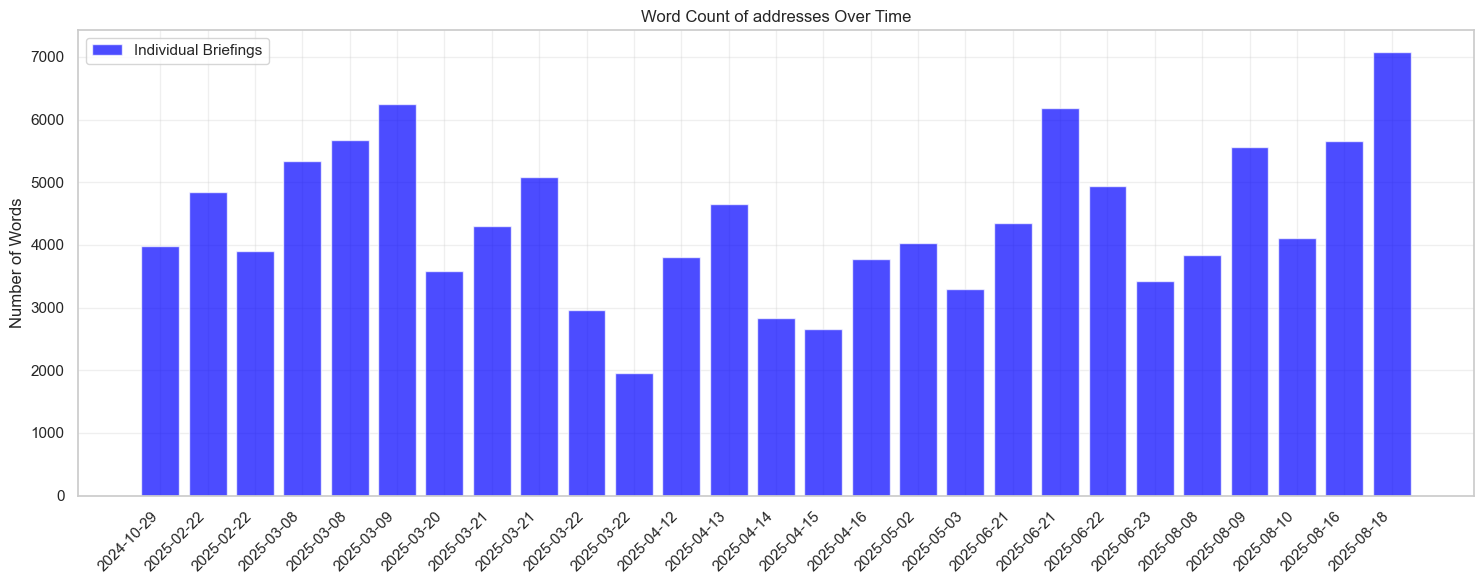


Word Count Summary:
Mean word count: 4374
Median word count: 4109
Min word count: 1960
Max word count: 7070


In [176]:
# Plot total word counts over time as a bar chart
plt.figure(figsize=(15, 6))

# Sort dataframe by date to ensure proper ordering
df_sorted = df.sort_values('date')

# Create sequential x positions for side-by-side plotting
x_positions = range(len(df_sorted))

# Create bar plot with sequential positions
bars = plt.bar(x_positions, df_sorted['text_length'], alpha=0.7, color='blue', label='Individual Briefings')

# Format x-axis with date labels at sequential positions
plt.xticks(x_positions, [d.strftime('%Y-%m-%d') for d in df_sorted['date']], rotation=45, ha='right')

plt.title('Word Count of addresses Over Time')
plt.xlabel('') # Remove x-axis label since dates are shown
plt.ylabel('Number of Words')
plt.legend()
plt.grid(True, alpha=0.3)

# Set y-axis to start at 0
plt.ylim(bottom=0)

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nWord Count Summary:")
print(f"Mean word count: {df['text_length'].mean():.0f}")
print(f"Median word count: {df['text_length'].median():.0f}")
print(f"Min word count: {df['text_length'].min():.0f}")
print(f"Max word count: {df['text_length'].max():.0f}")


## Phrase Frequency Analysis

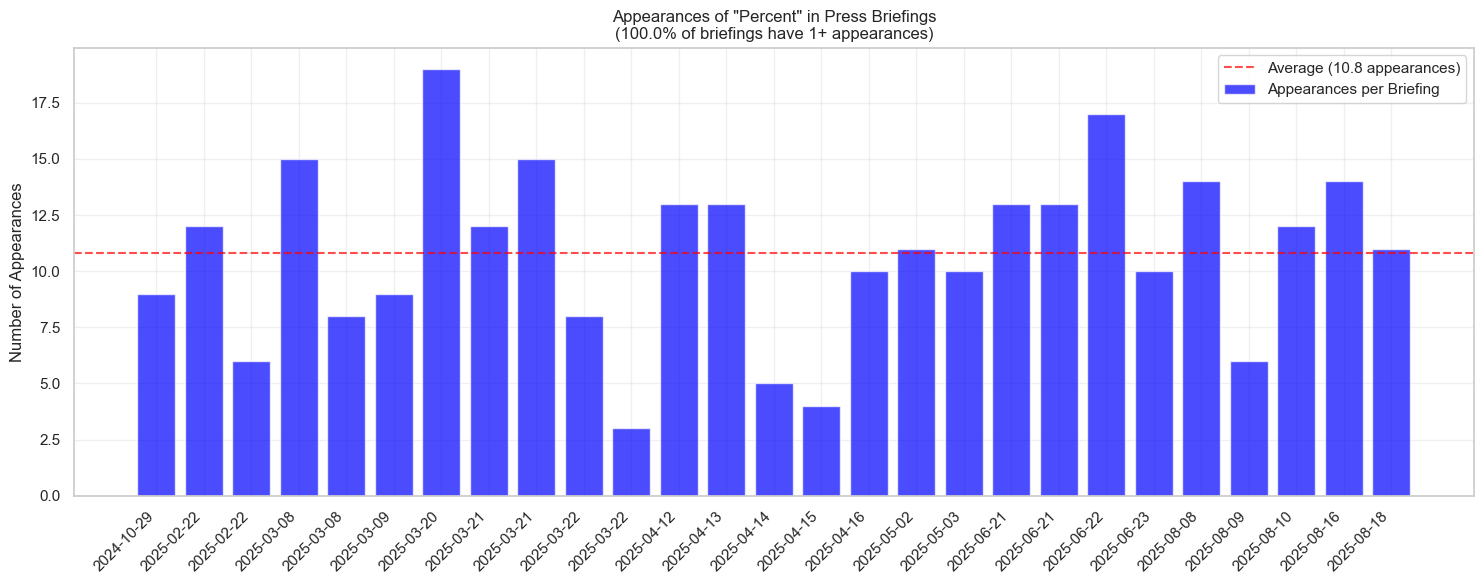

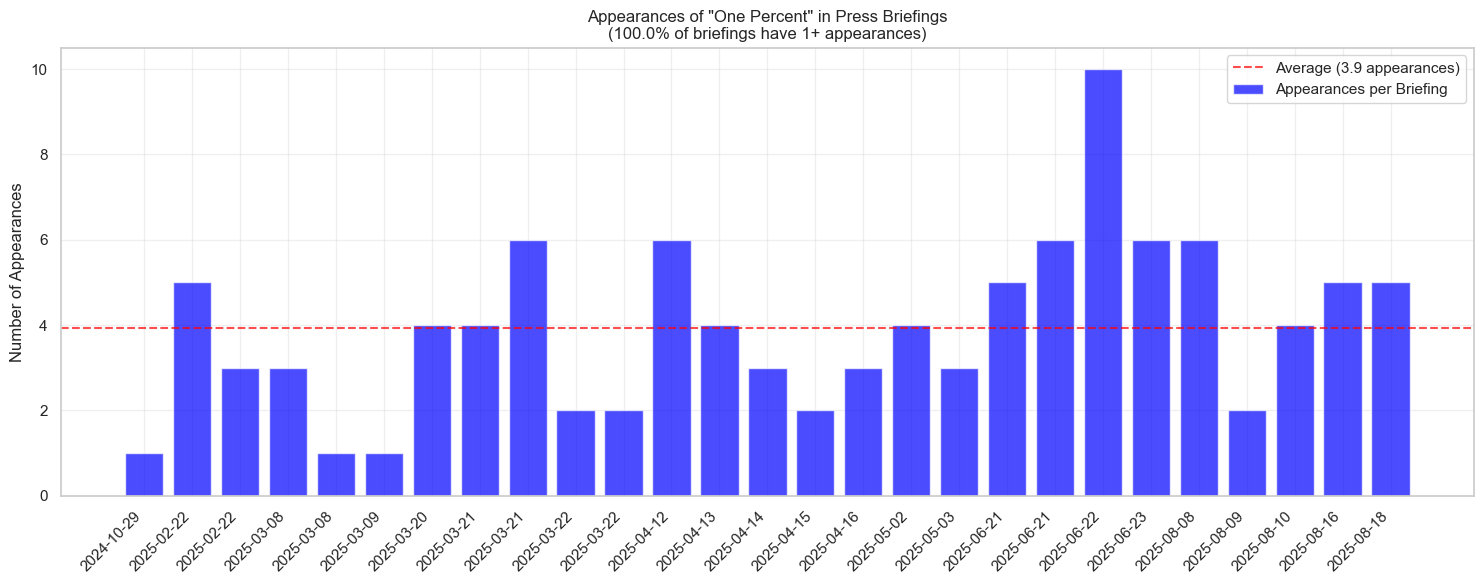

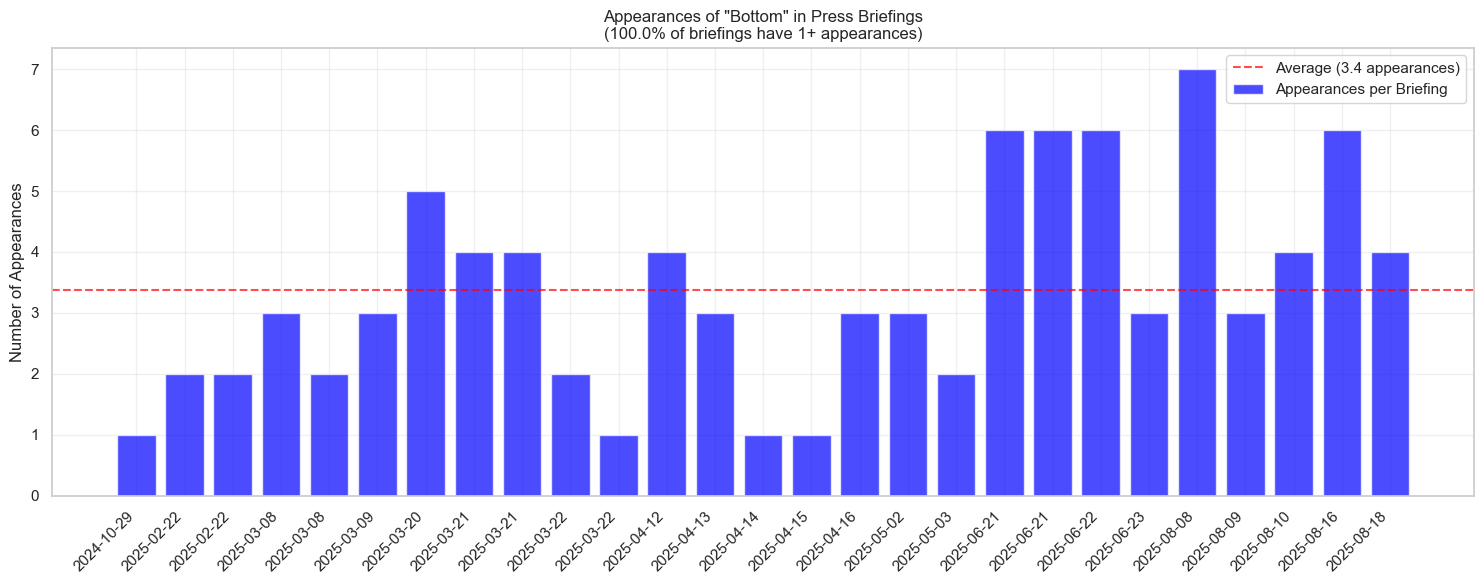

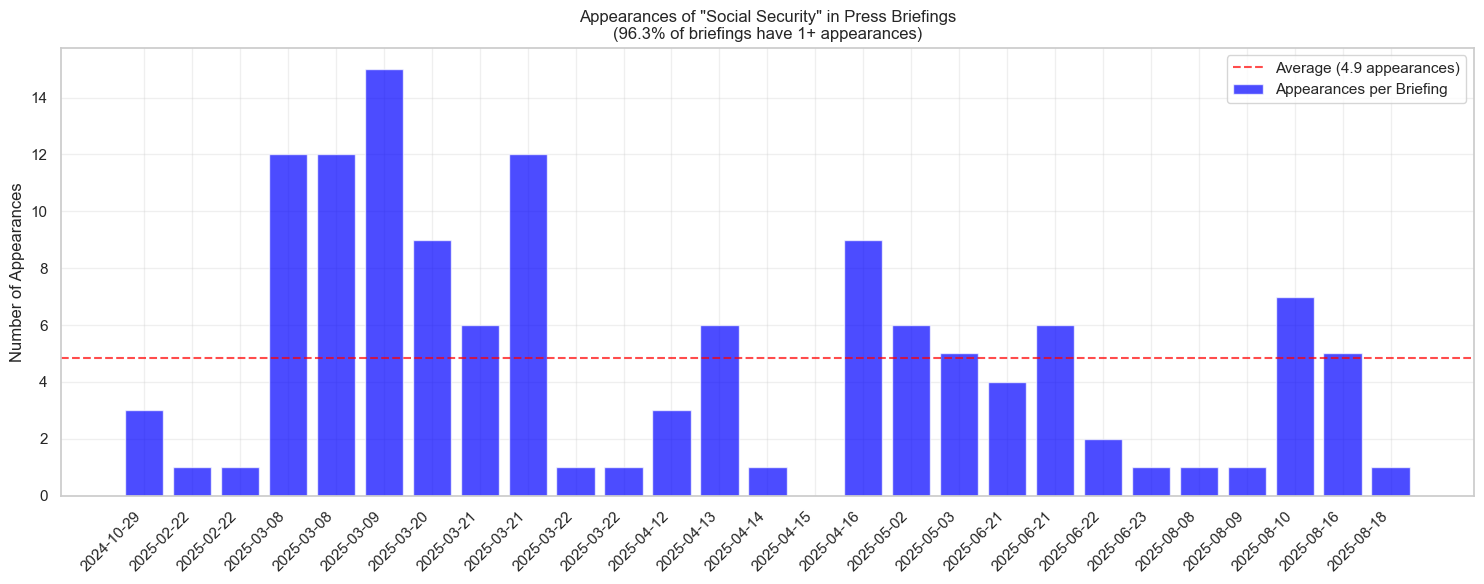

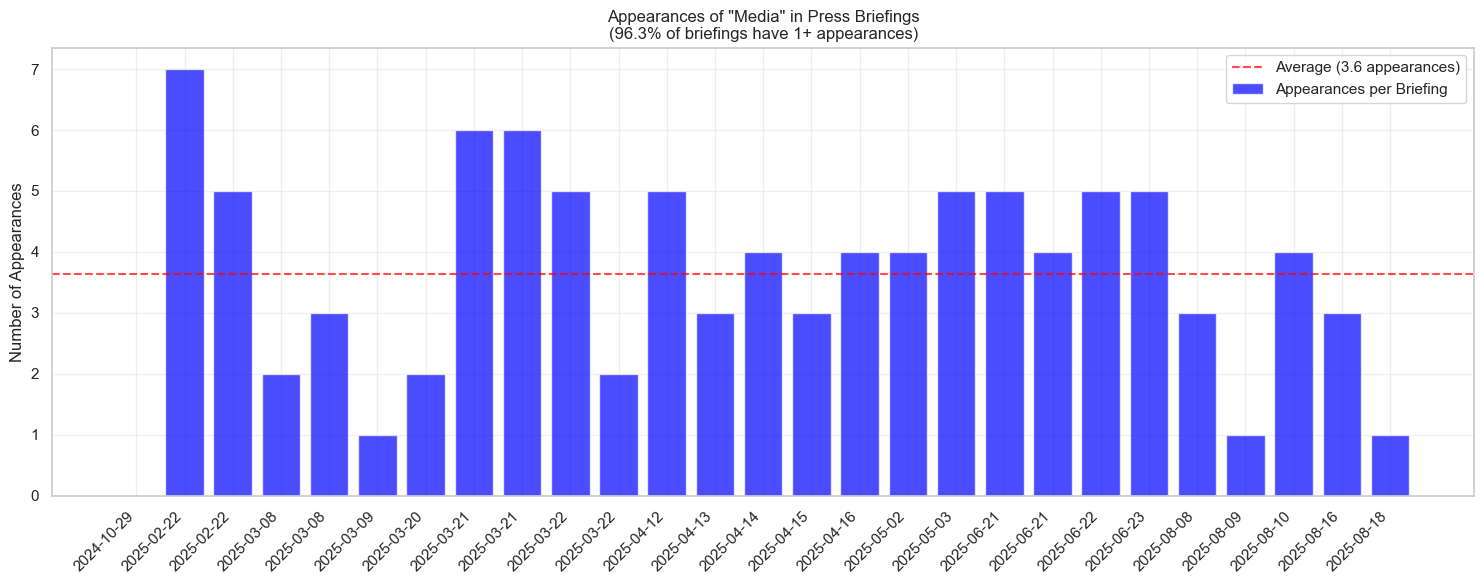

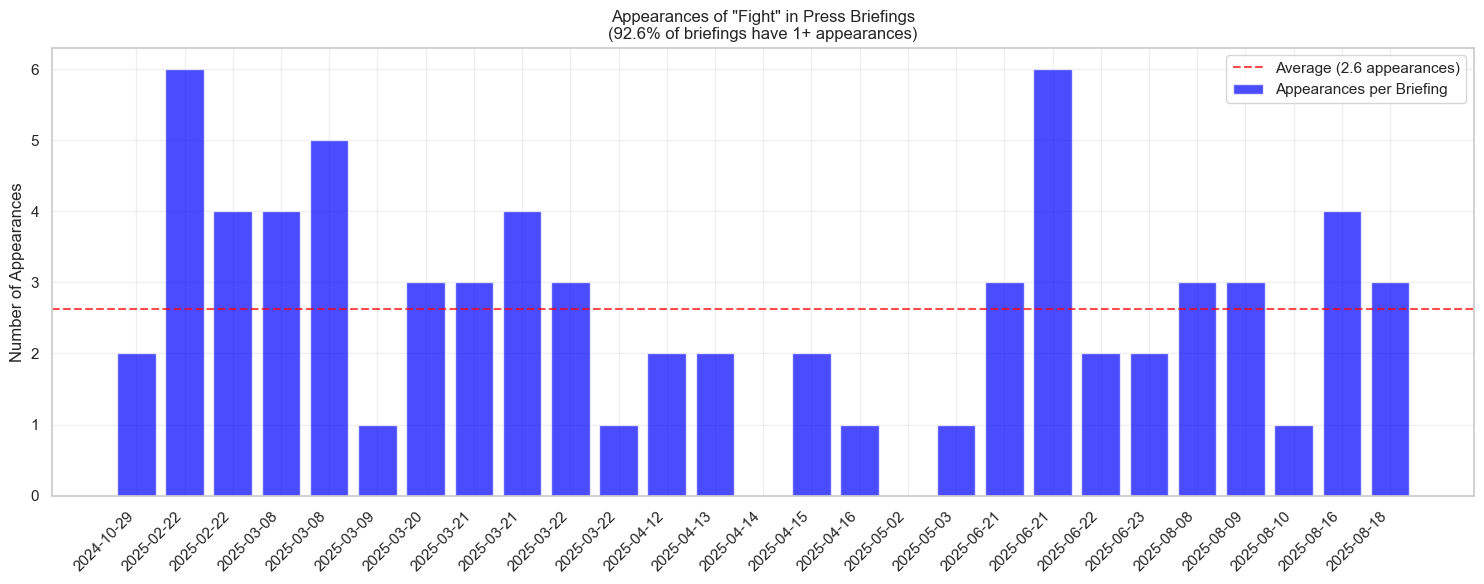

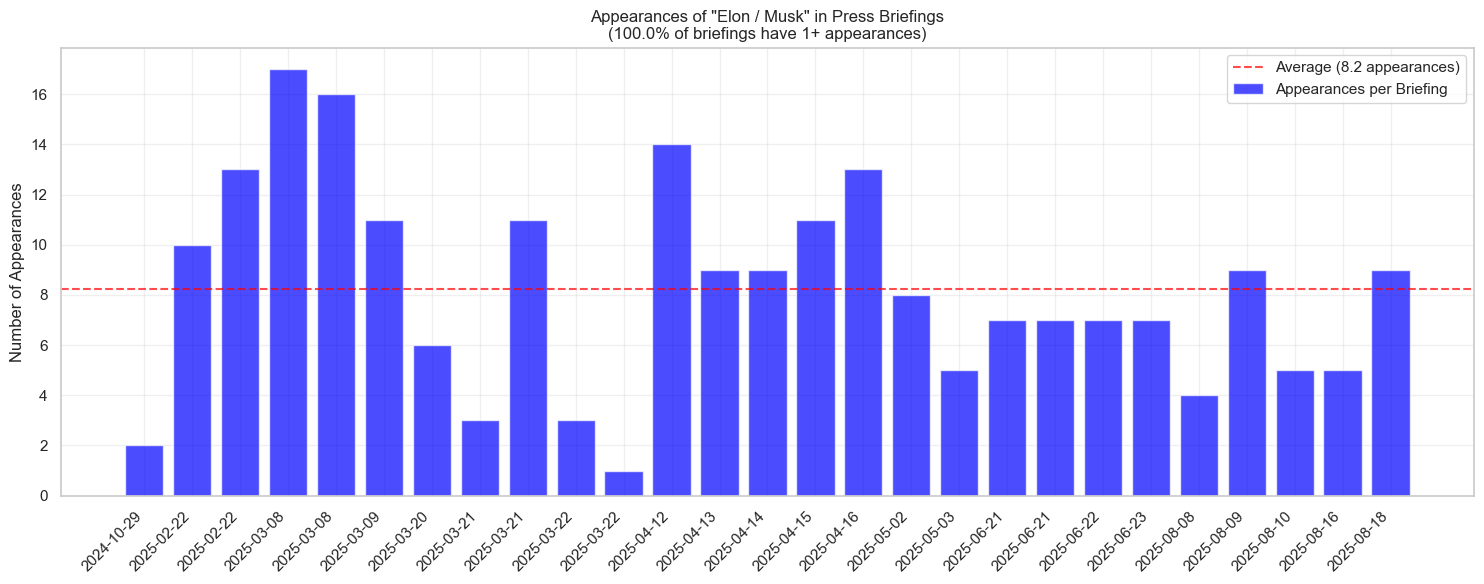

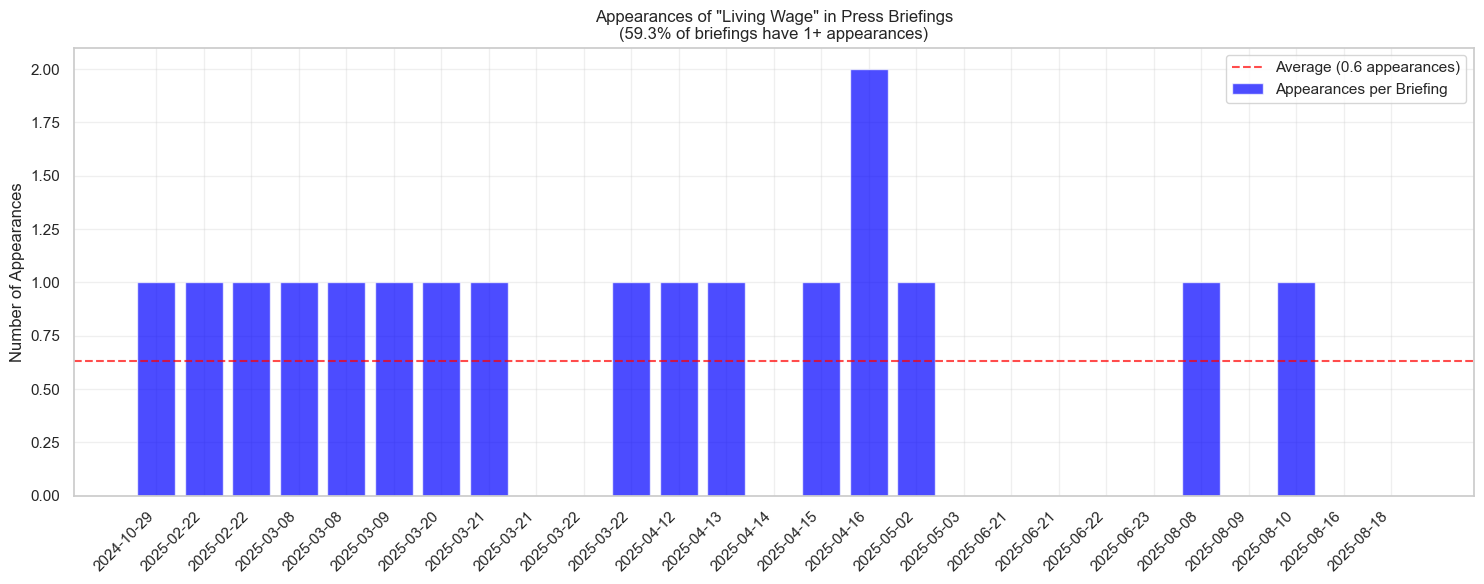

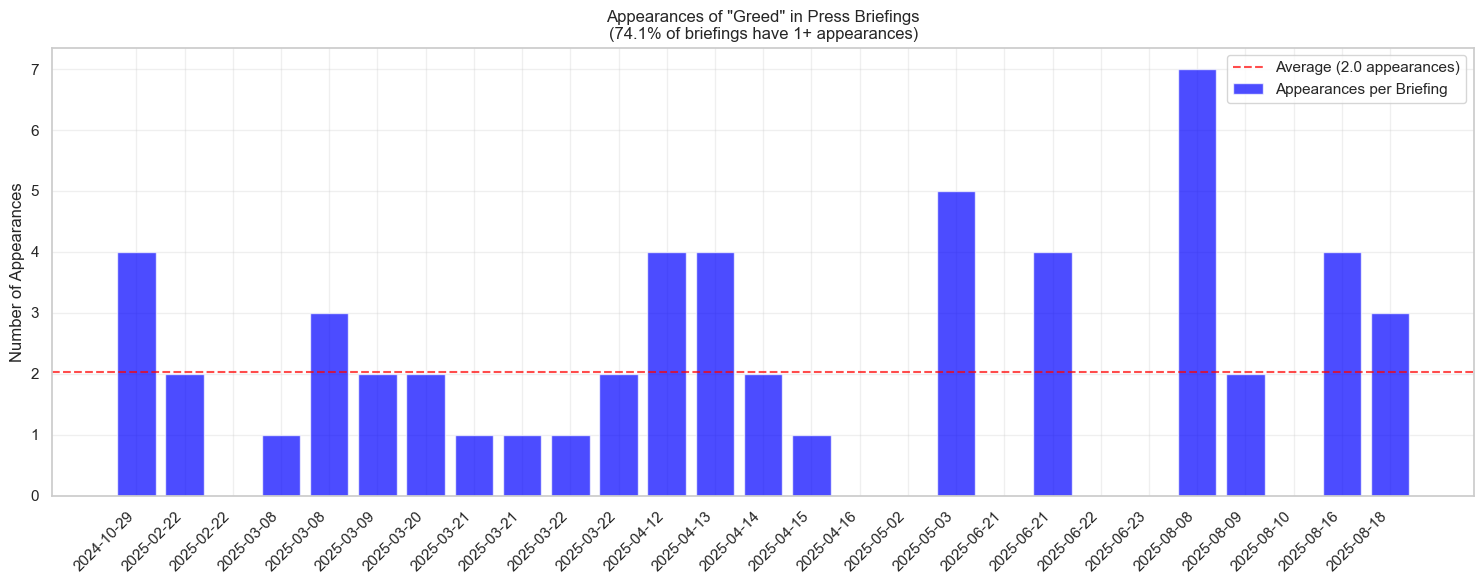

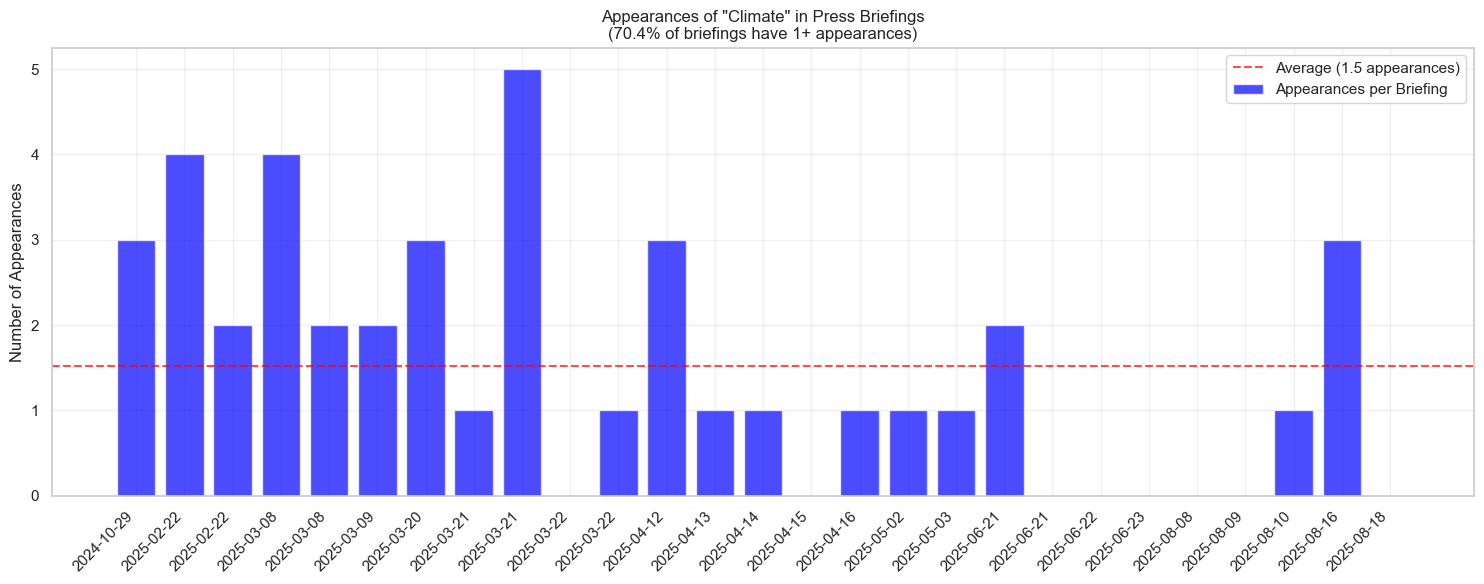

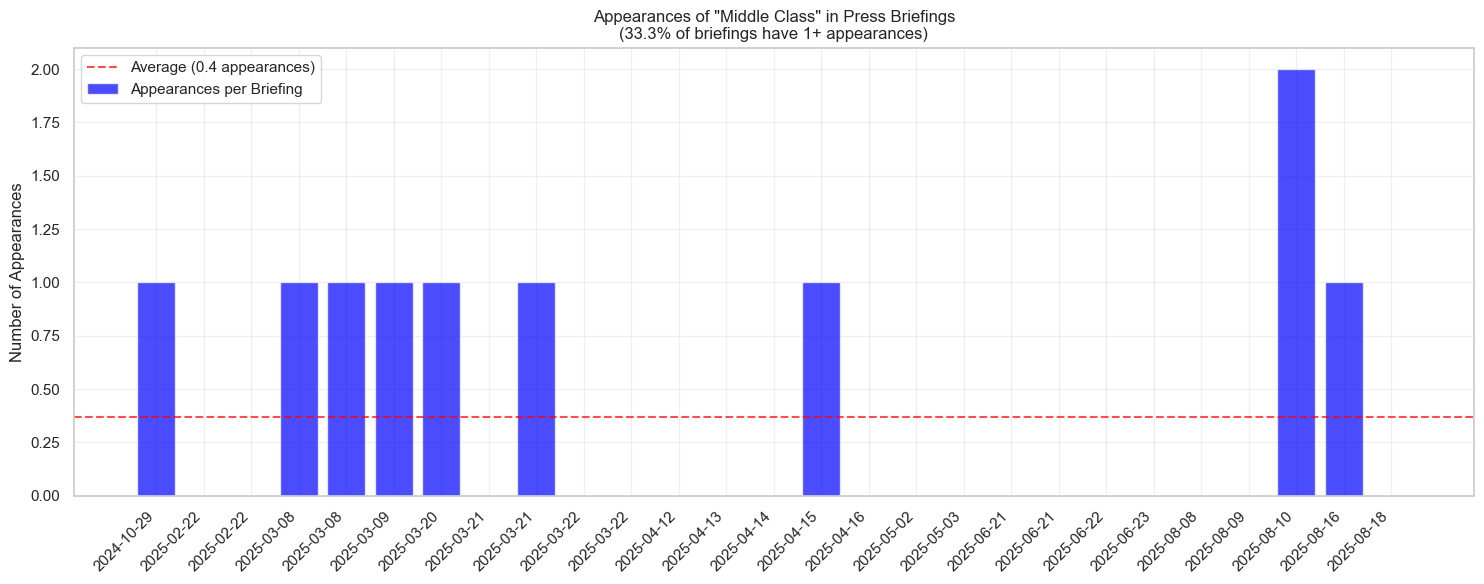

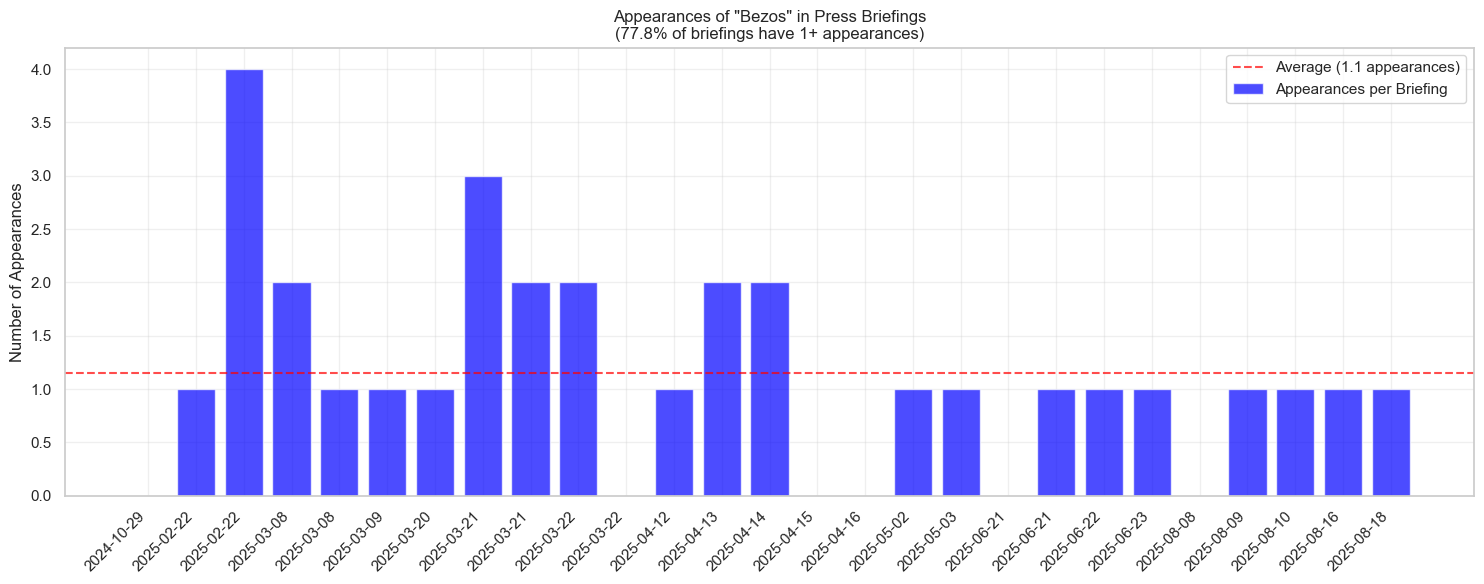

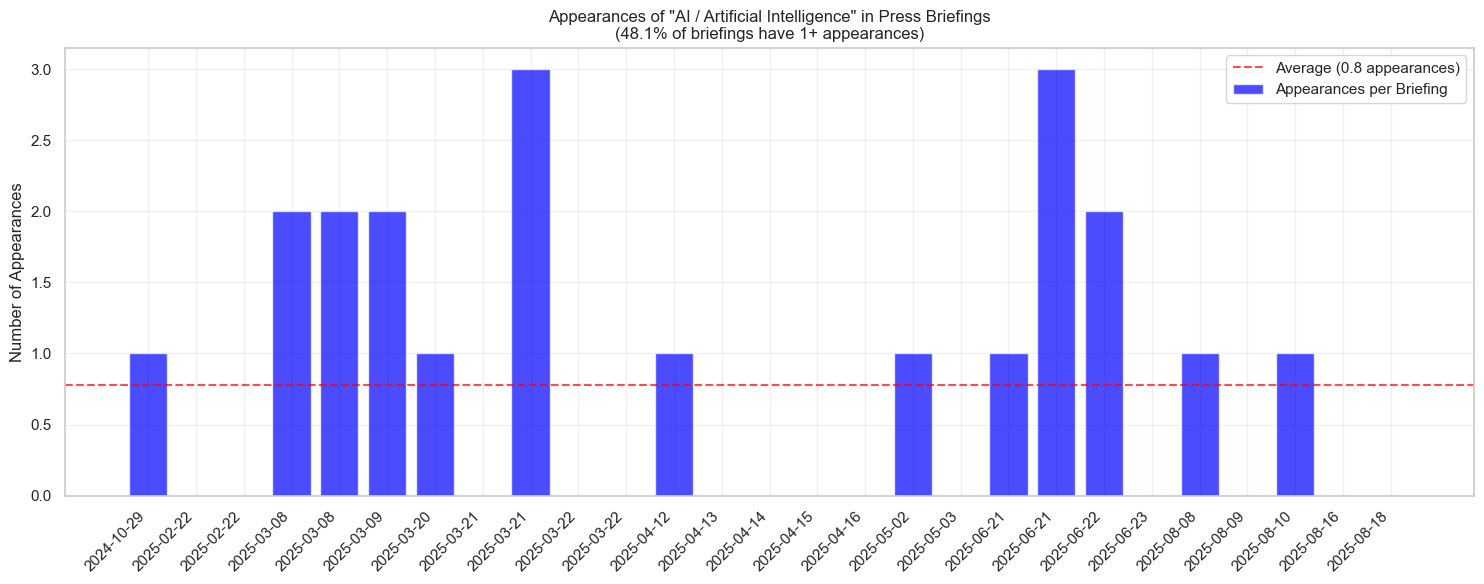

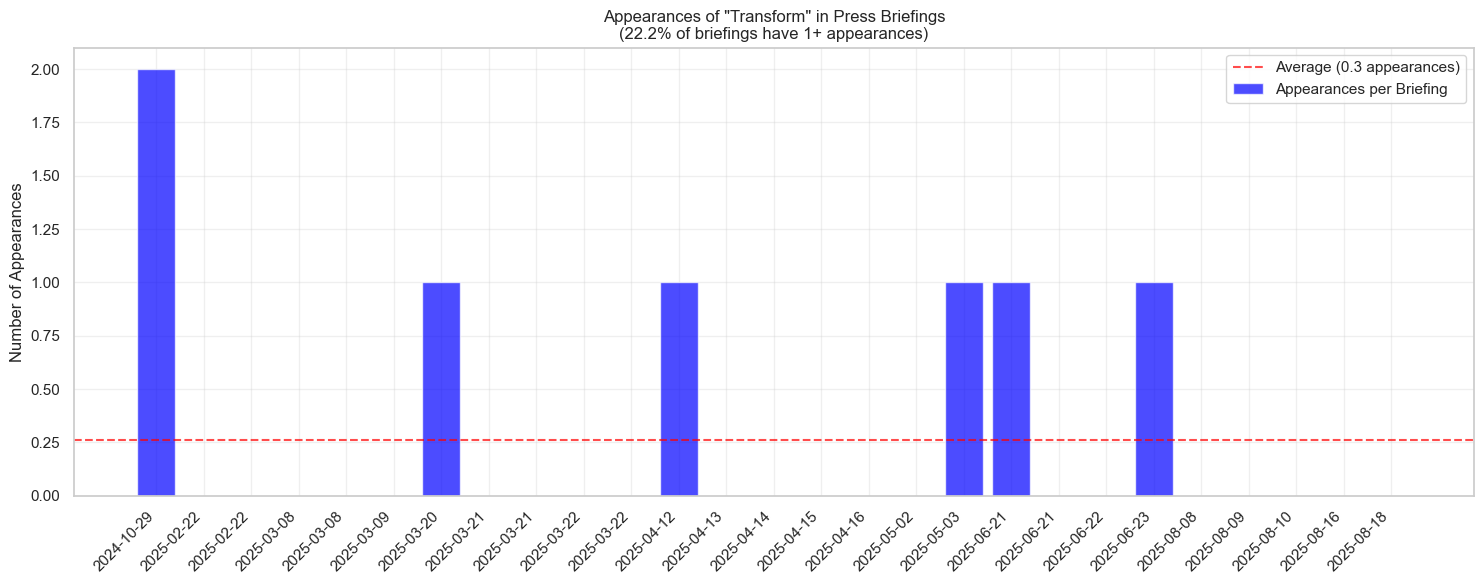

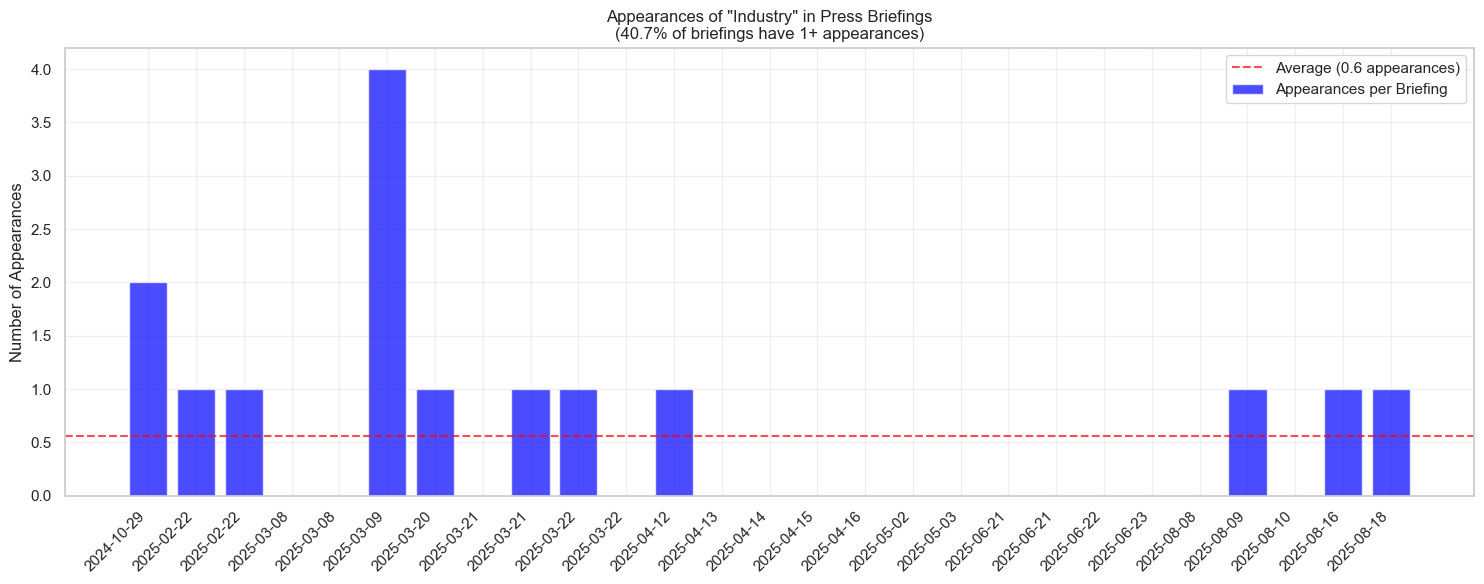

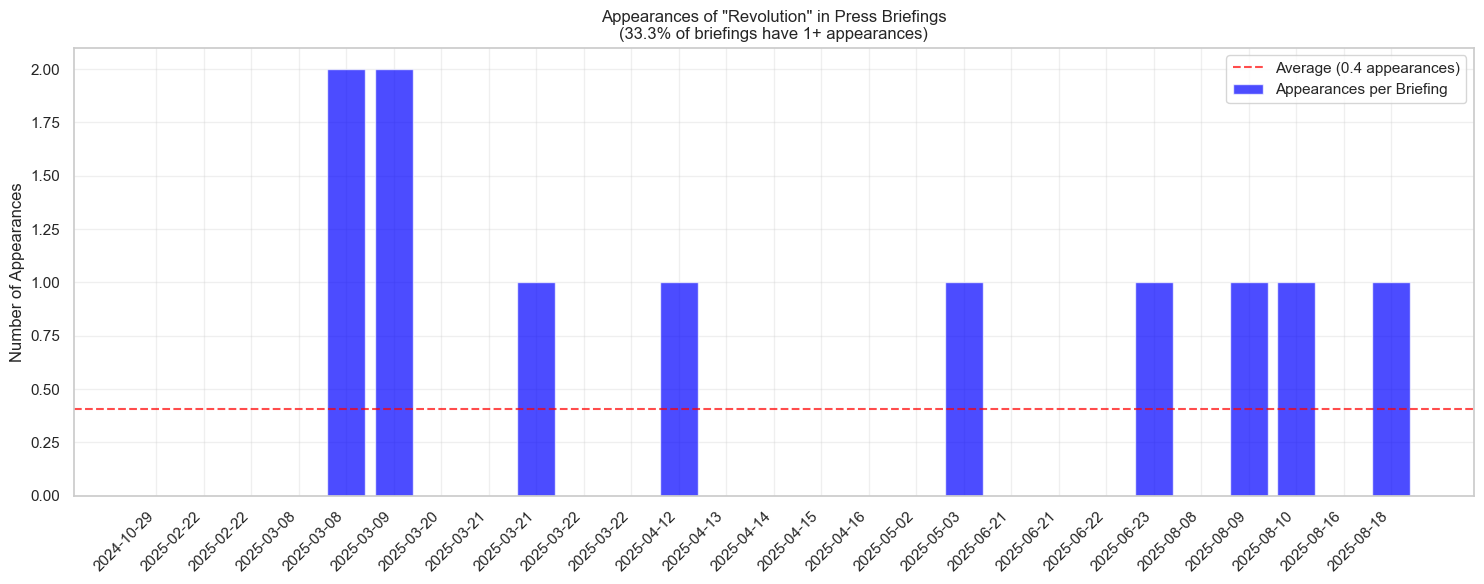

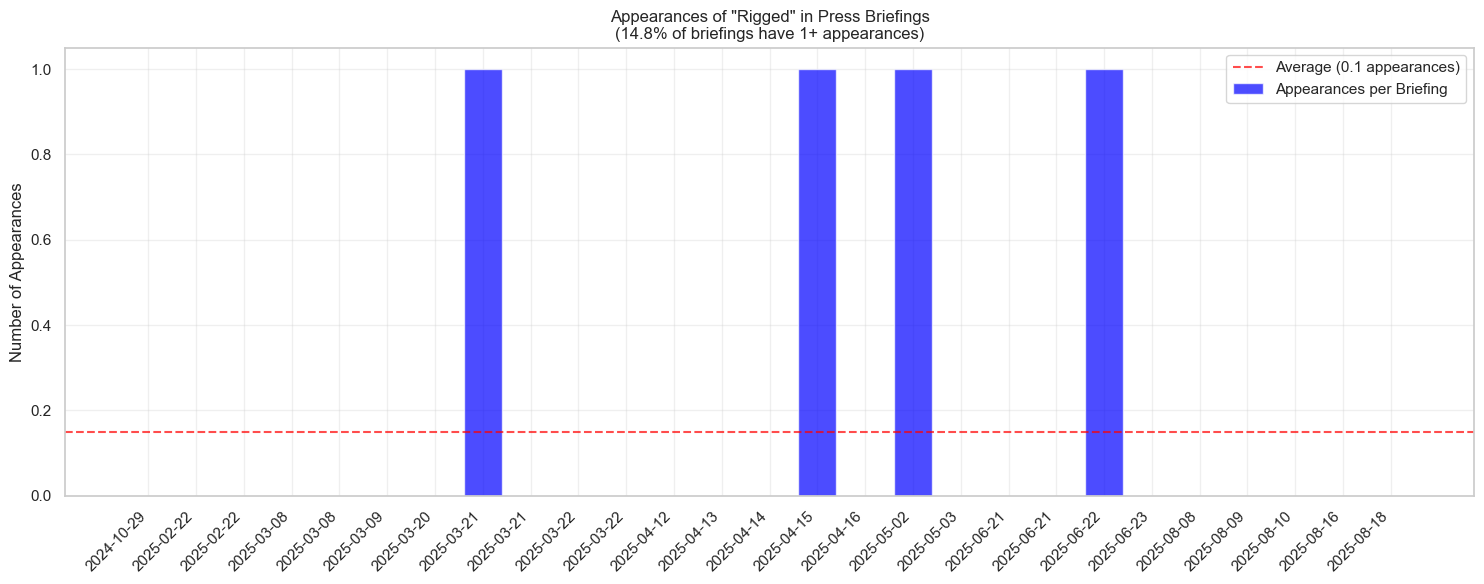

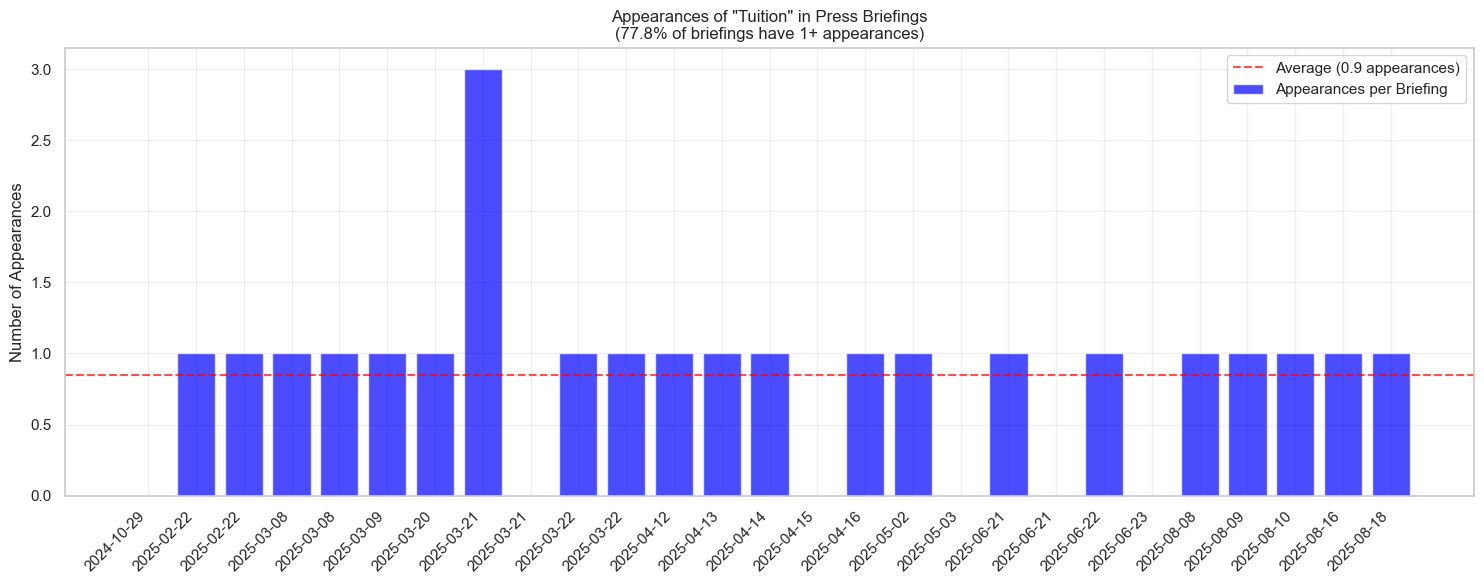

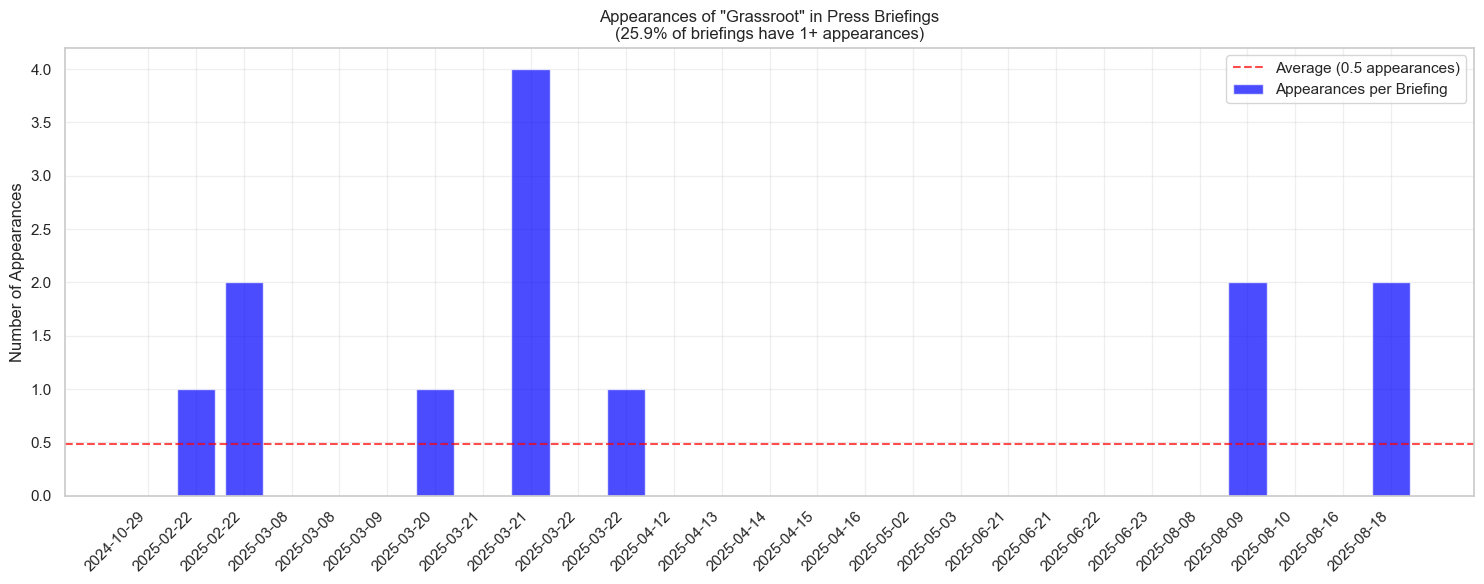

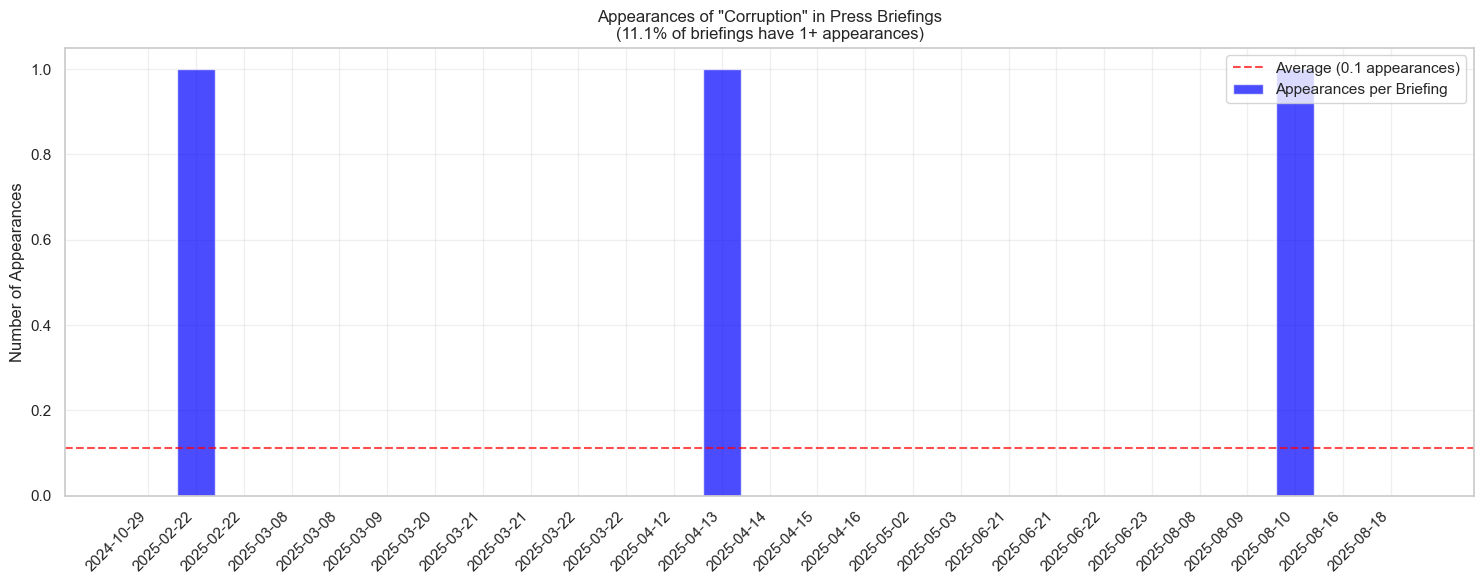

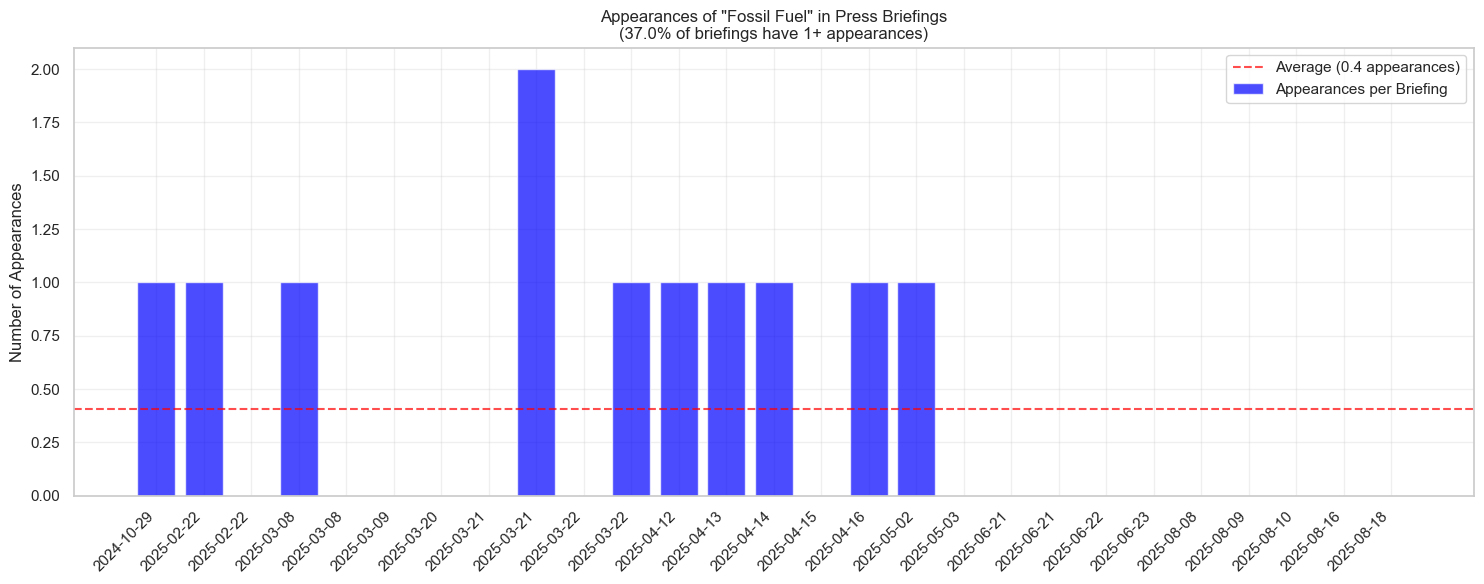

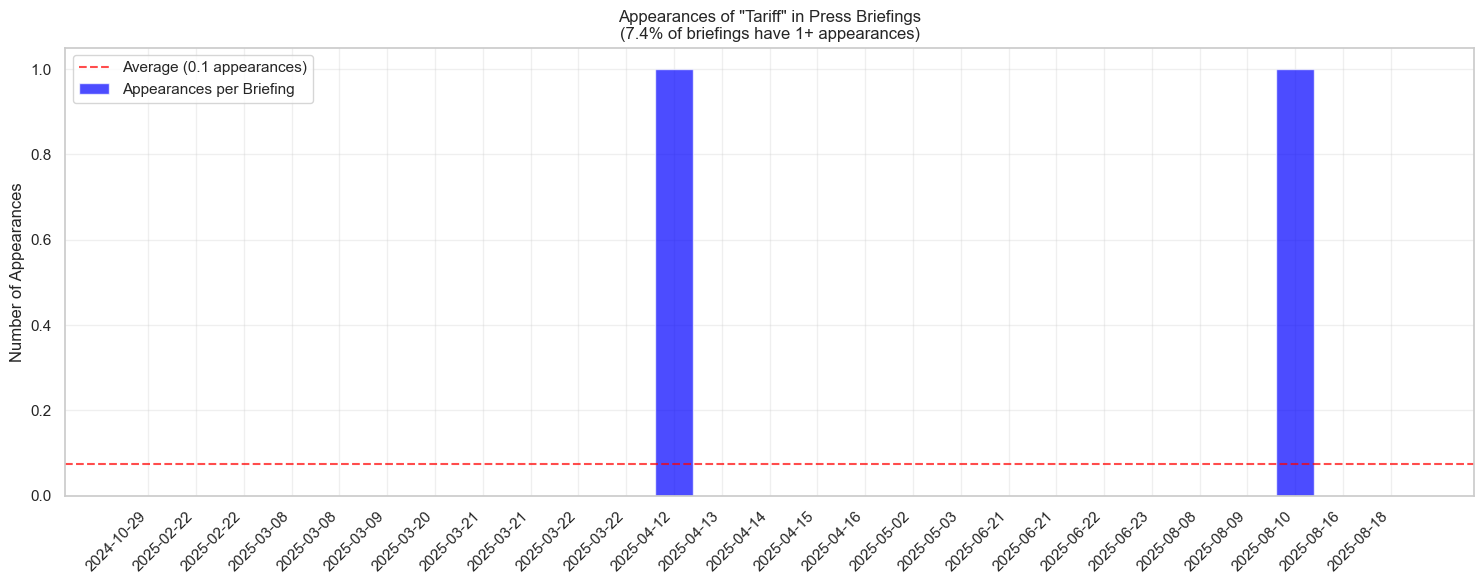

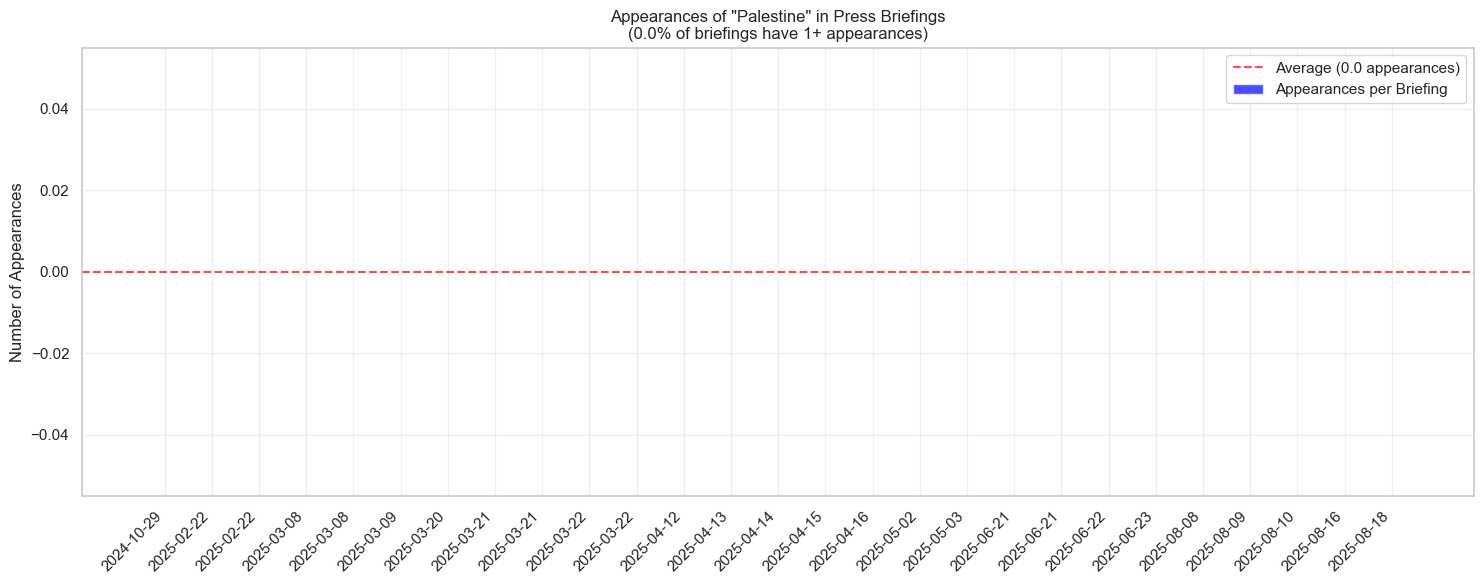

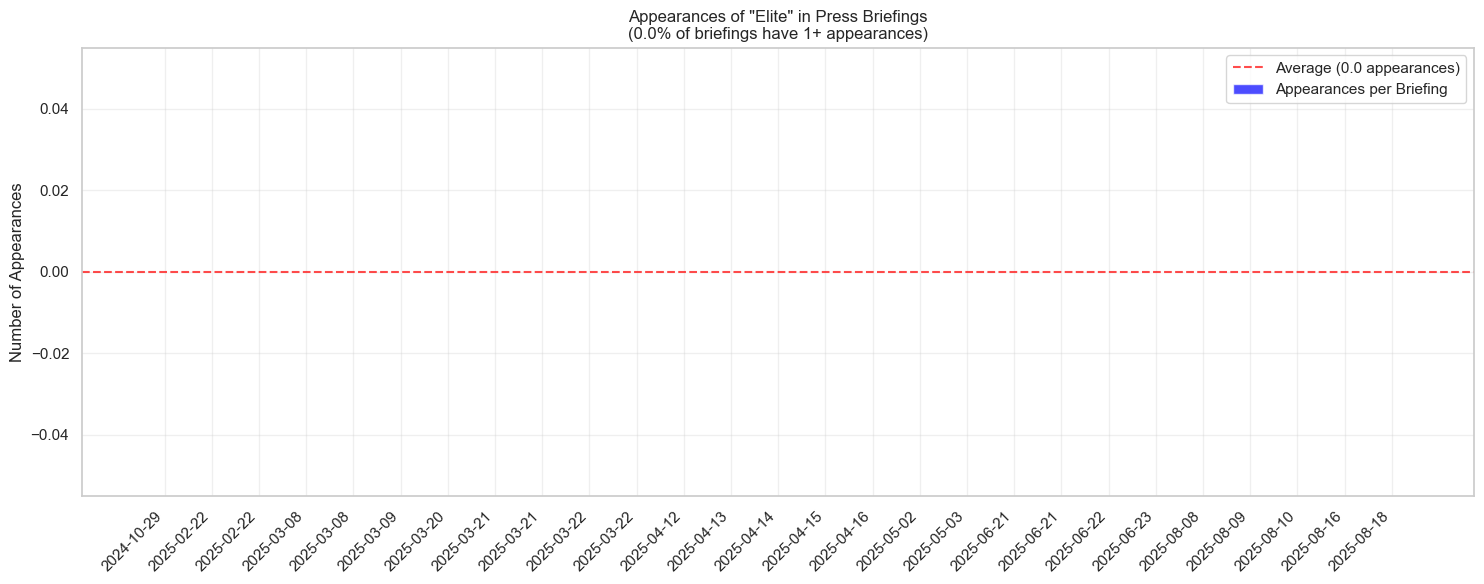

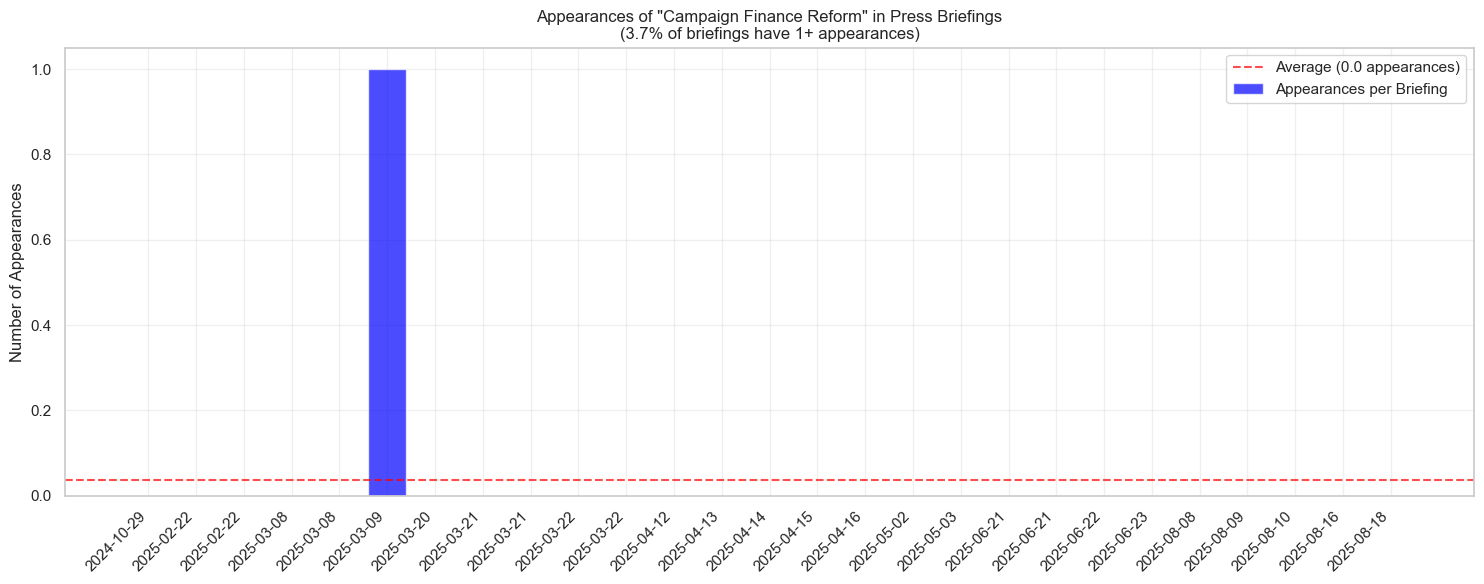

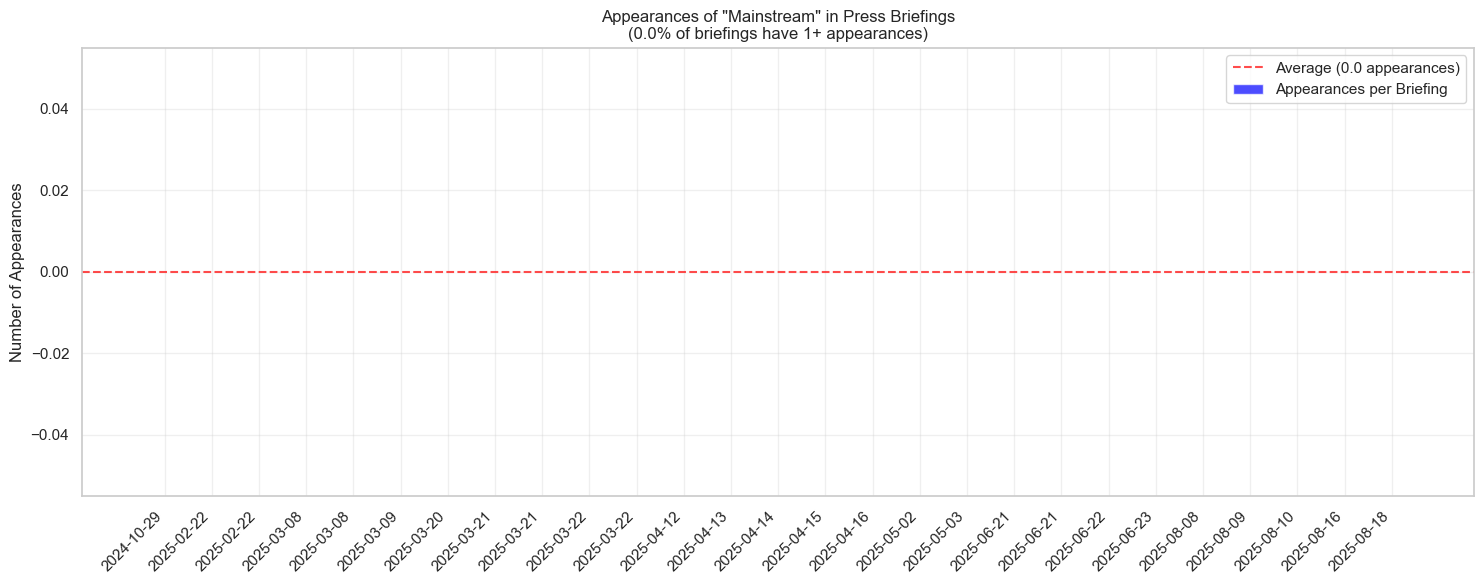

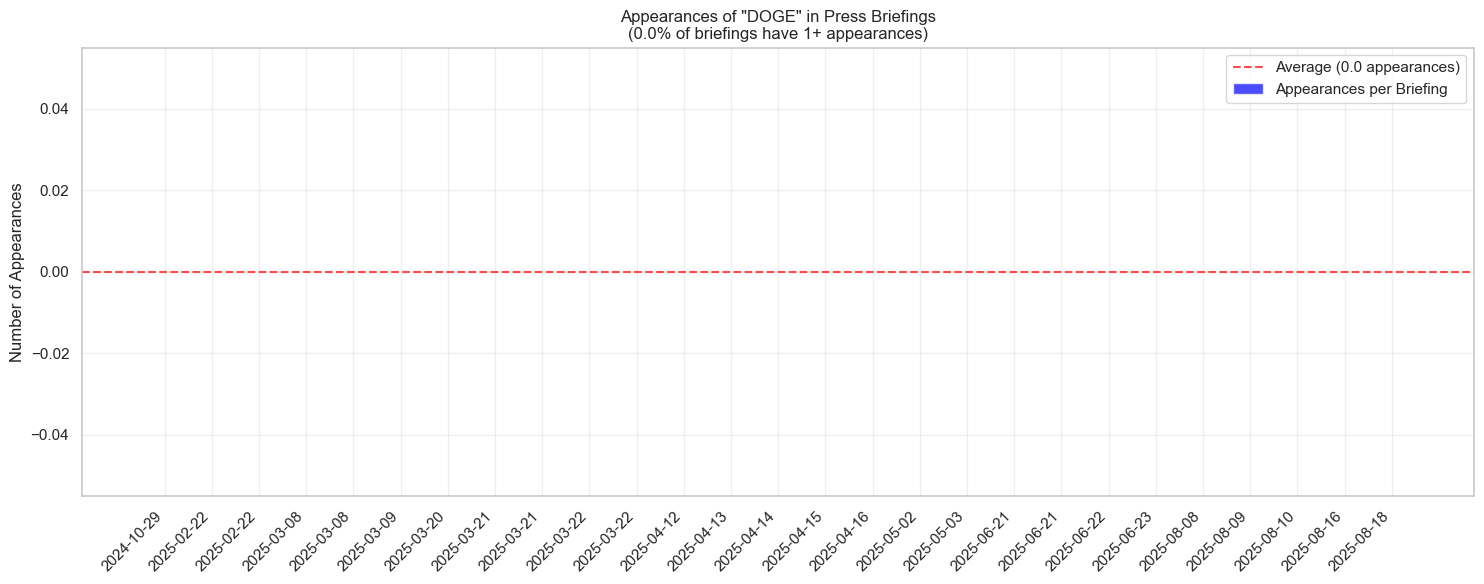

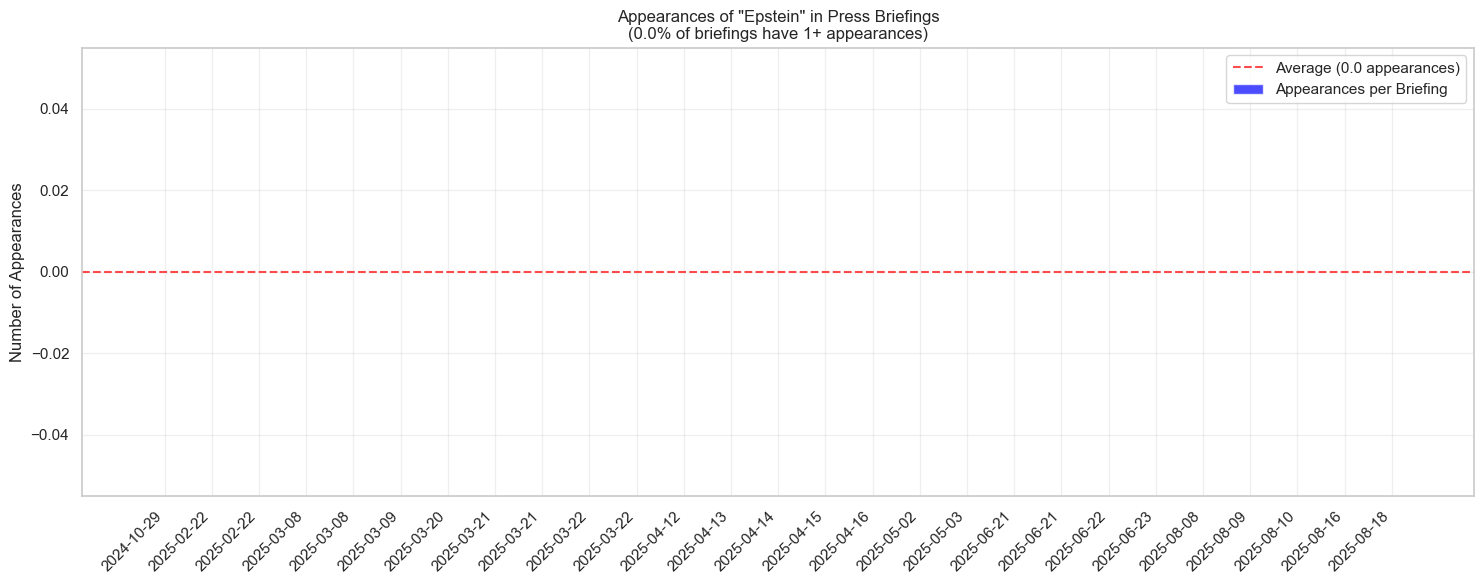

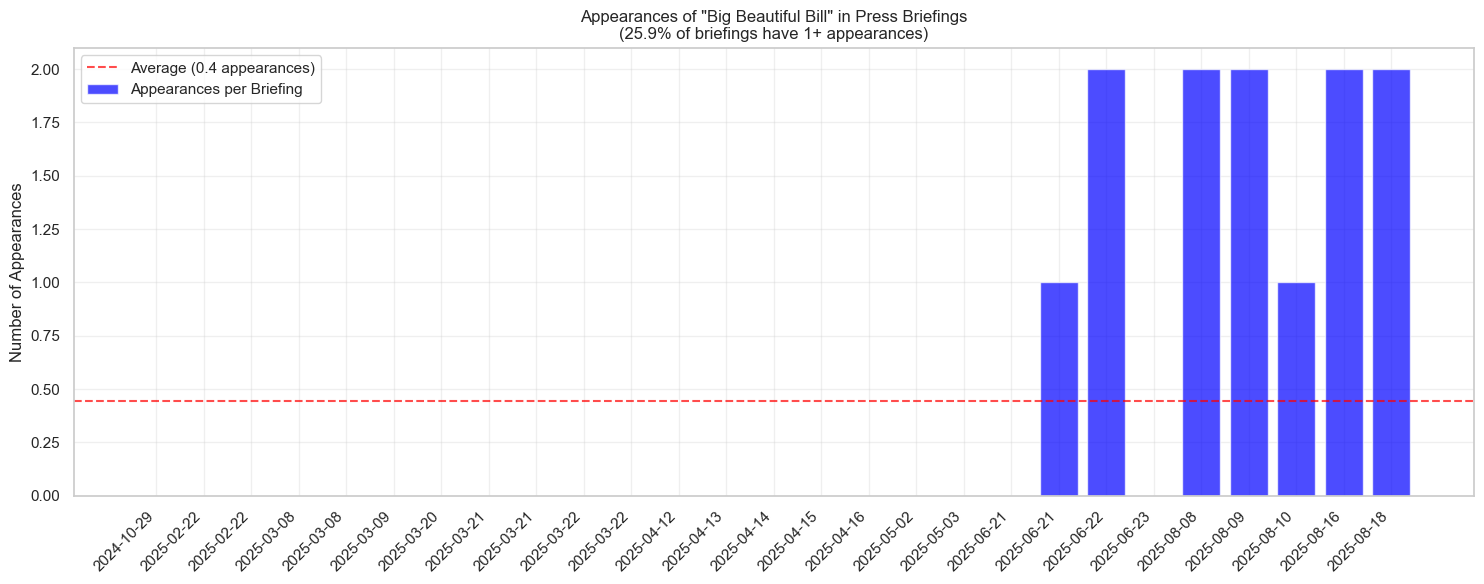

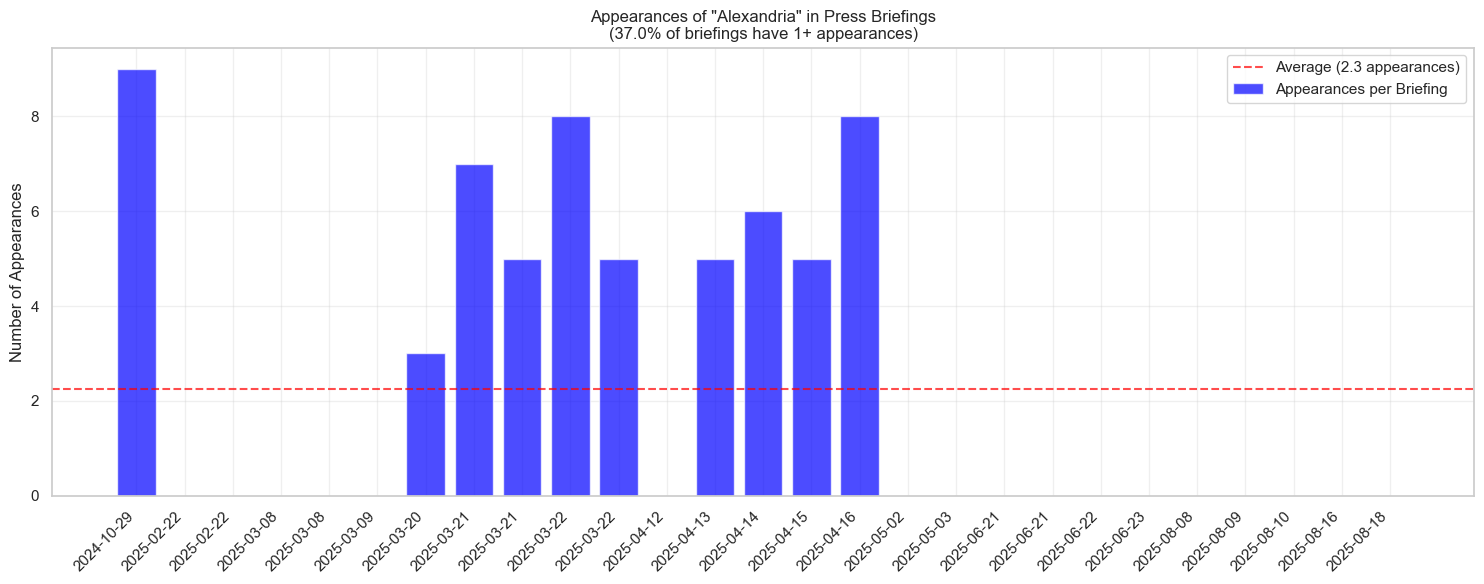

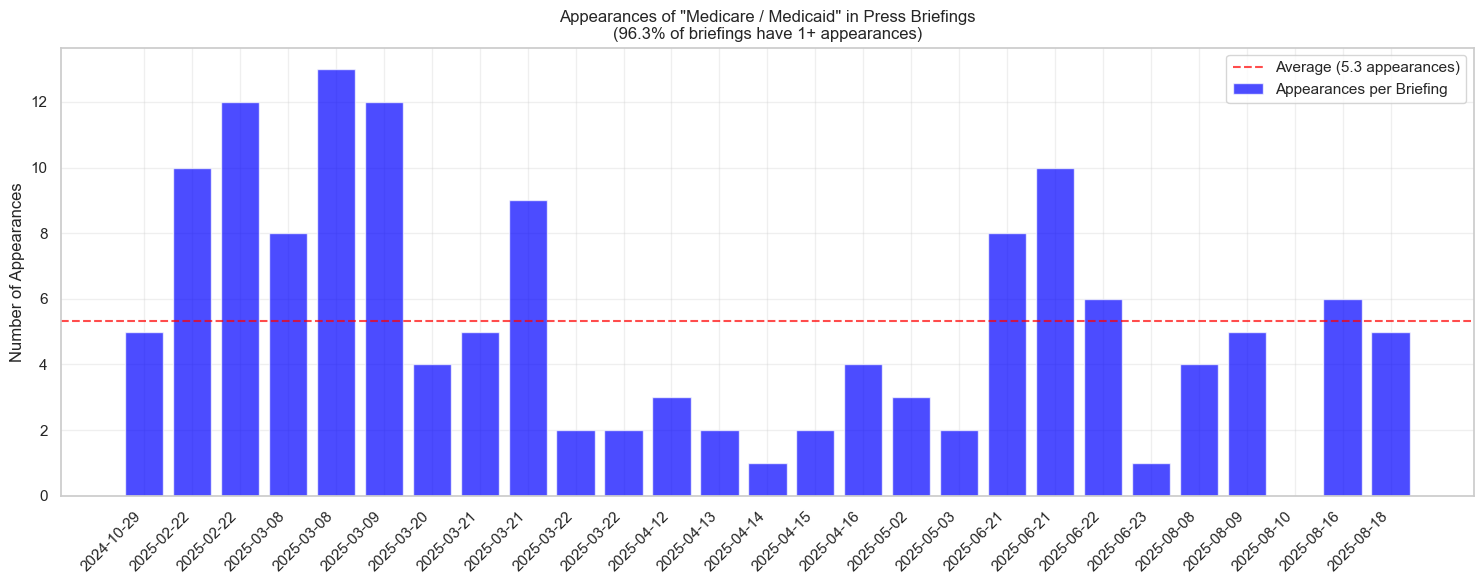

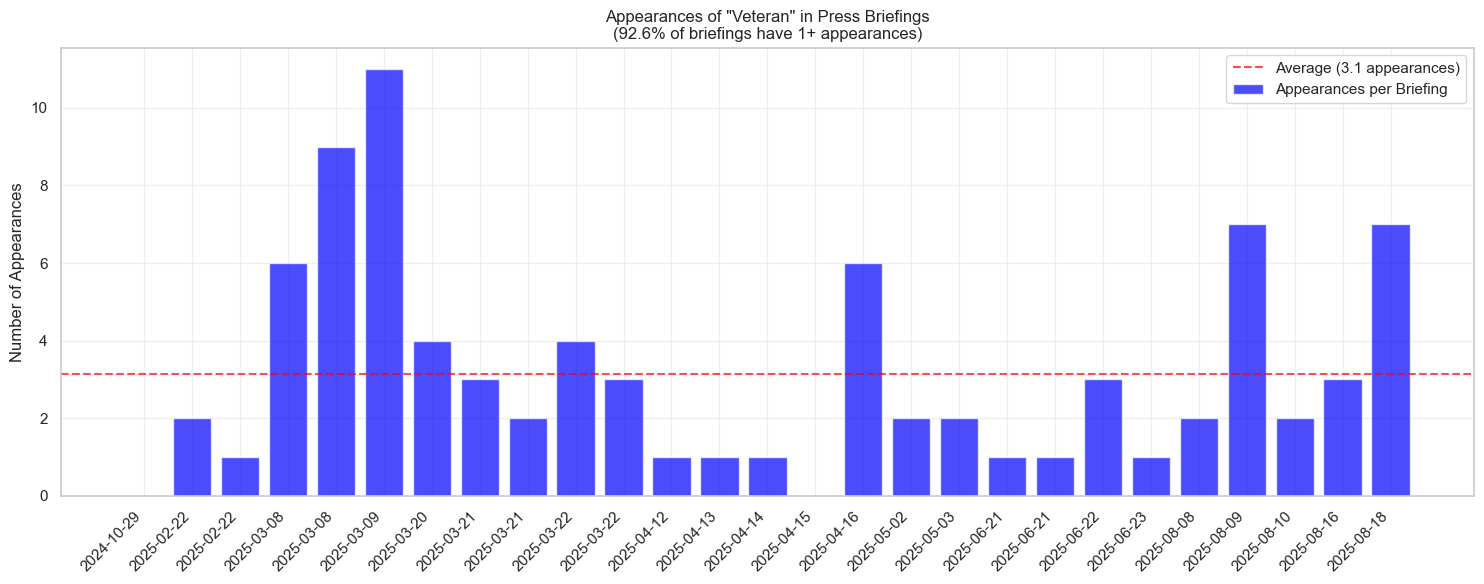

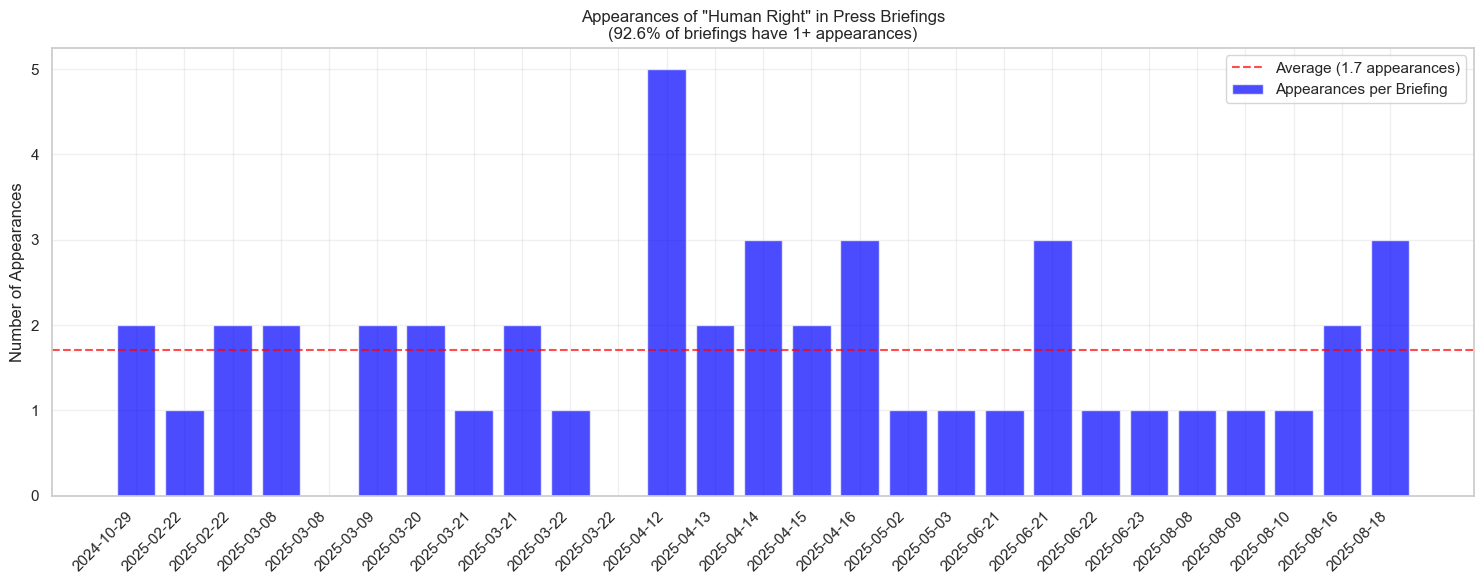

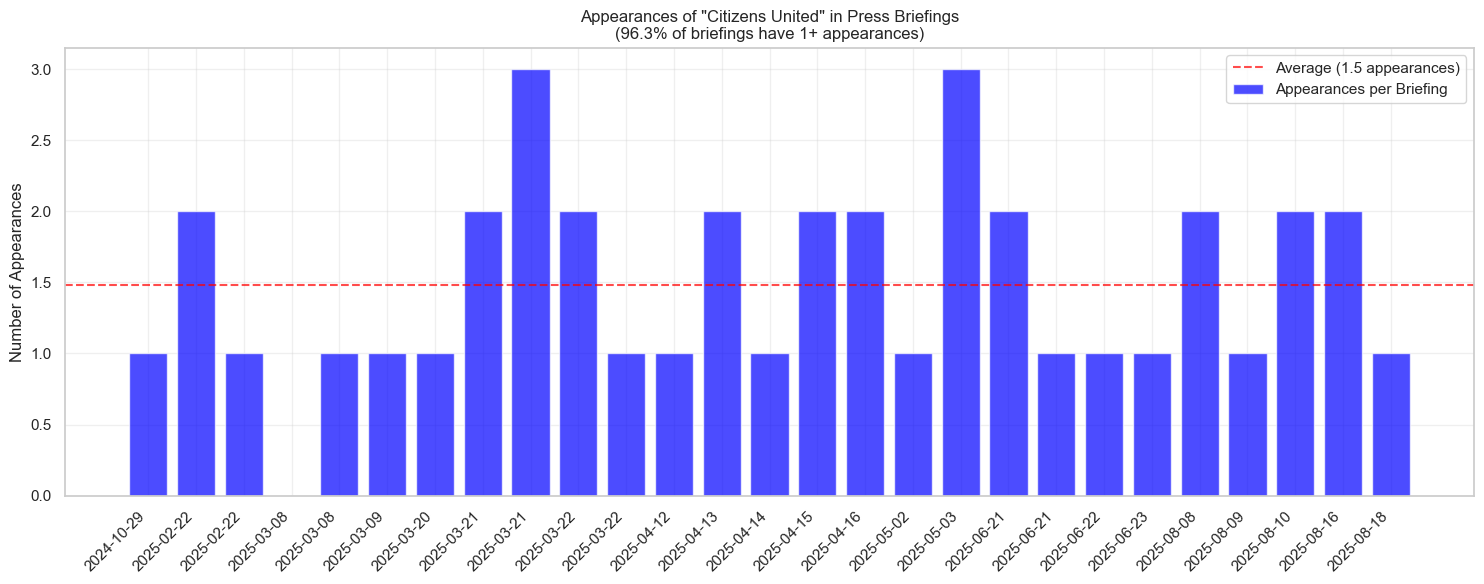

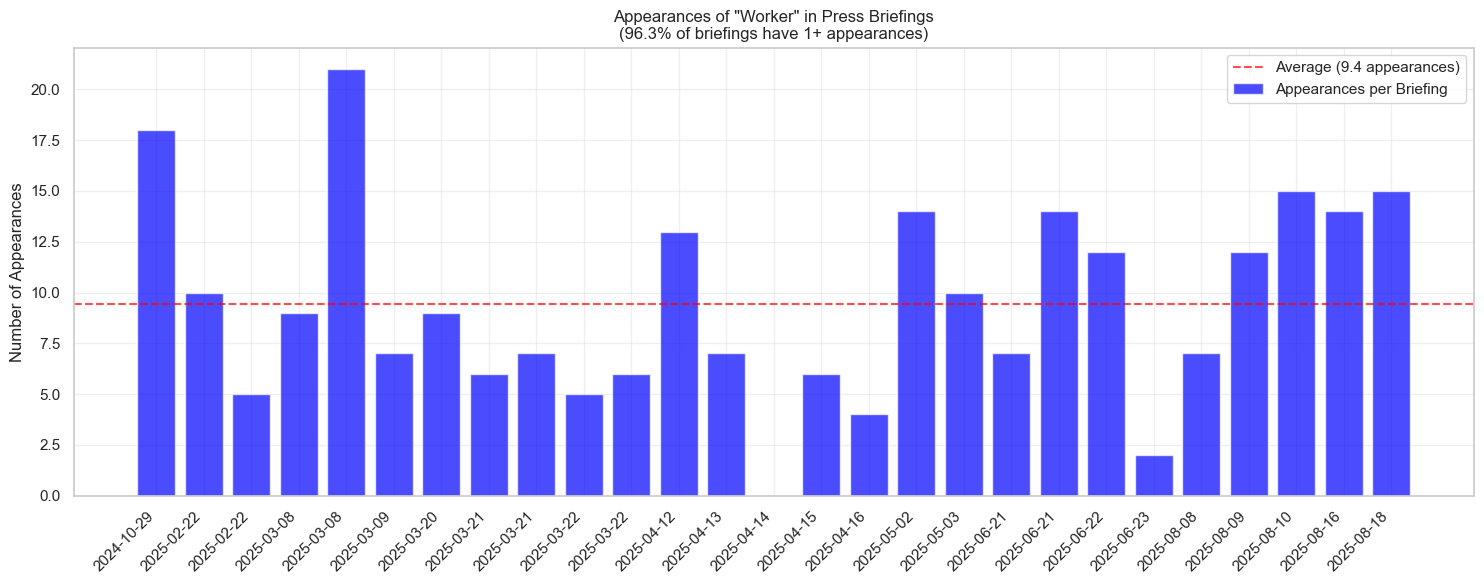

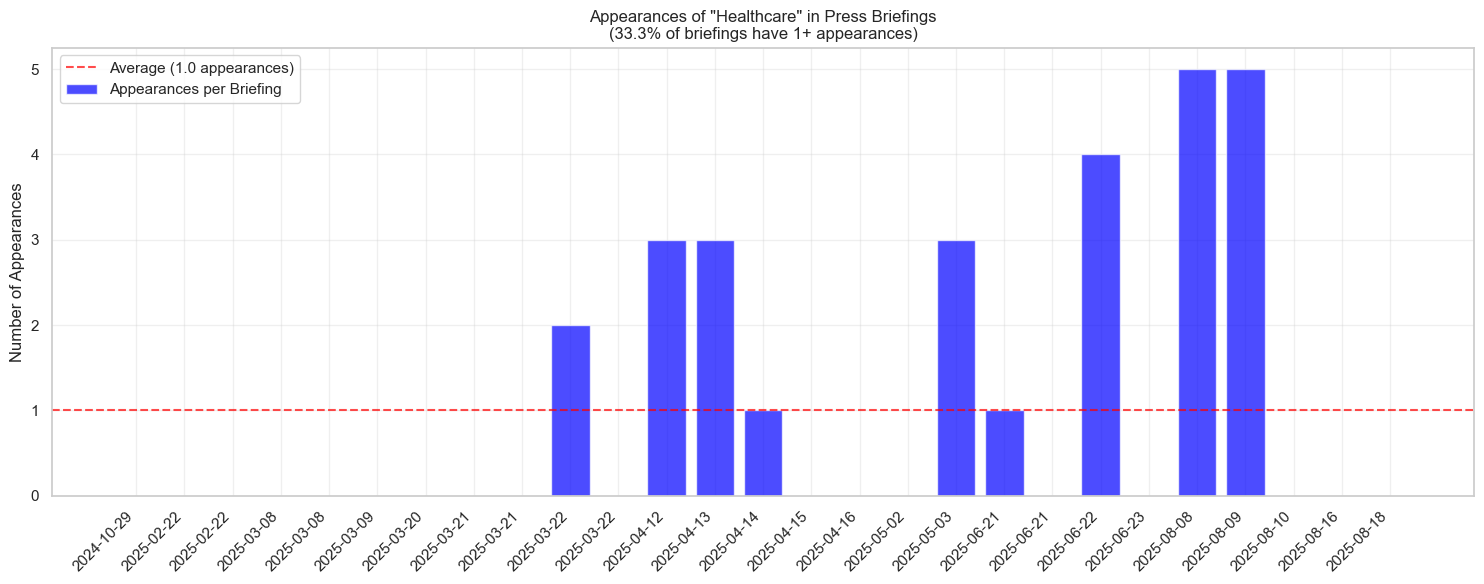

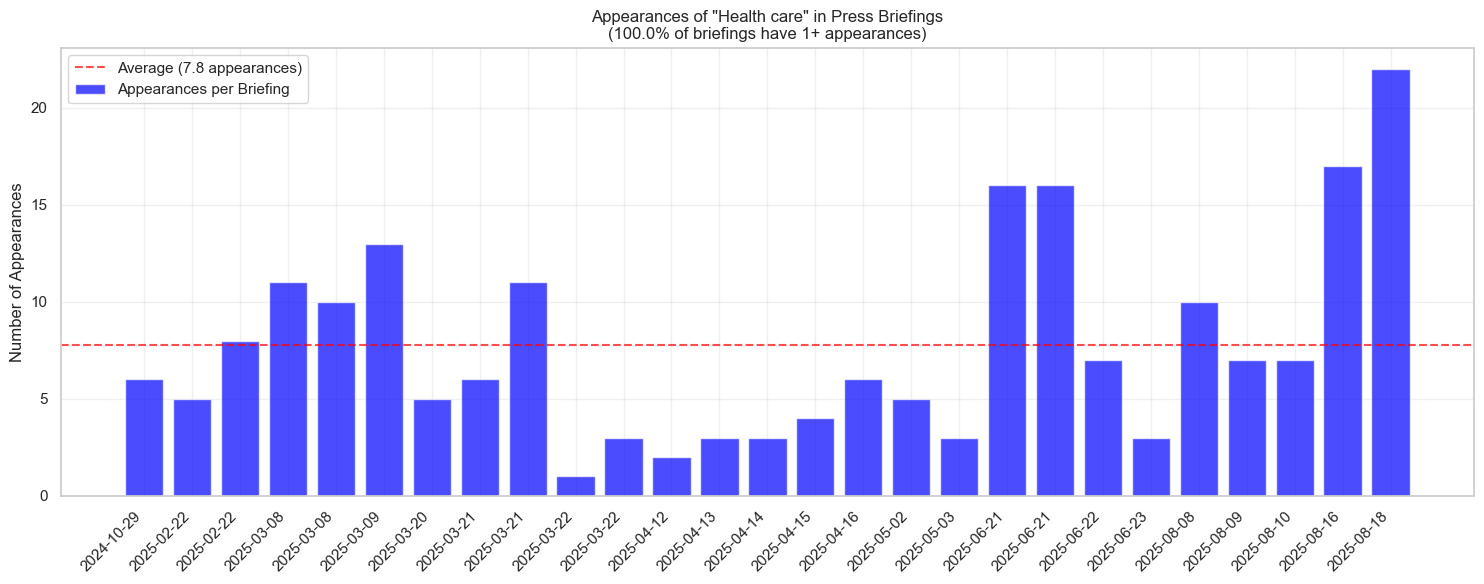

In [177]:
def plot_phrase_frequency_over_time(df, phrase):
    """Plot the frequency of a phrase over time"""
    plt.figure(figsize=(15, 6))
    
    # Get raw counts and dates, sorted by date
    df_sorted = df.sort_values('date')
    counts = df_sorted[phrase]
    dates = df_sorted['date']
    
    # Calculate average and percentage with 1+ appearances
    avg = counts.mean()
    pct_with_appearances = (counts > 0).mean() * 100
    
    # Create sequential x positions (0, 1, 2, 3, ...)
    x_positions = range(len(counts))
    
    # Create bar plot with sequential positions
    bars = plt.bar(x_positions, counts, alpha=0.7, color='blue', 
                   label='Appearances per Briefing')
    
    # Add horizontal line for average
    plt.axhline(y=avg, color='red', linestyle='--', alpha=0.7, 
                label=f'Average ({avg:.1f} appearances)')
    
    # Format x-axis with date labels at sequential positions
    plt.xticks(x_positions, [d.strftime('%Y-%m-%d') for d in dates], 
               rotation=45, ha='right')
    
    plt.title(f'Appearances of "{phrase}" in Press Briefings\n({pct_with_appearances:.1f}% of briefings have 1+ appearances)')
    plt.xlabel('')  # Remove x-axis label since dates are shown
    plt.ylabel('Number of Appearances')
    plt.legend()
    plt.grid(True, alpha=0.3)

    
    plt.tight_layout()
    plt.show()

# Plot time series for all phrases
for phrase in SEARCH_PHRASES.keys():
    plot_phrase_frequency_over_time(df, phrase)

## Recent Usage in Context

In [178]:
def get_recent_contexts(df, phrase, n=5):
    """Get the n most recent contexts for a phrase"""
    all_matches = []
    
    for _, row in df.sort_values('date', ascending=False).iterrows():
        matches = find_phrase_context(row['text'], SEARCH_PHRASES[phrase])
        for match in matches:
            all_matches.append({
                'date': row['date'],
                'context': match
            })
        if len(all_matches) >= n:
            break
    
    return pd.DataFrame(all_matches[:n])

# Get recent contexts for each phrase
for phrase in SEARCH_PHRASES.keys():
    contexts = get_recent_contexts(df, phrase)
    if not contexts.empty:
        print(f"\n=== Recent usage of '{phrase}' ===\n")
        for _, row in contexts.iterrows():
            print(f"Date: {row['date'].strftime('%Y-%m-%d')}")
            print(f"Context: {row['context']}\n")


=== Recent usage of 'Percent' ===

Date: 2025-08-18
Context: ...about is something that you don't see much in the media and you don't hear much in Congress. And that is you are living in a country today where one person, Mr. Musk, owns more wealth than the bottom 52% of American households. You got that? One person, more wealth, some 400 billion, than the bottom 52% of American households. In America today, the top 1% owns more wealth than the bottom 93%. CEOs of...

Date: 2025-08-18
Context: ... is you are living in a country today where one person, Mr. Musk, owns more wealth than the bottom 52% of American households. You got that? One person, more wealth, some 400 billion, than the bottom 52% of American households. In America today, the top 1% owns more wealth than the bottom 93%. CEOs of large companies make 350 times what their workers make. That is America today. People on top, 1%, ha...

Date: 2025-08-18
Context: ..., Mr. Musk, owns more wealth than the bottom 52% of American 

## Phrase Co-occurrence Analysis

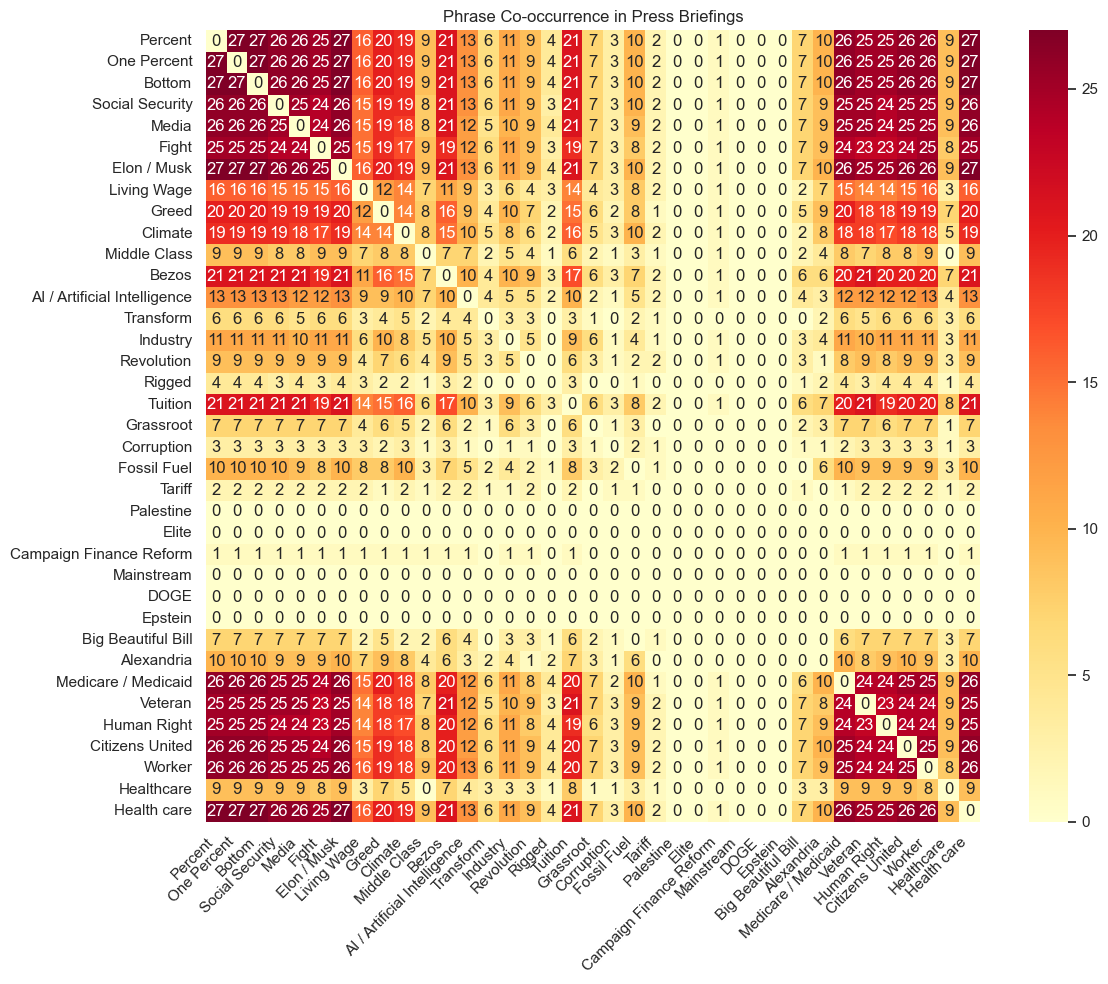

In [179]:
# Create co-occurrence matrix
phrase_cols = list(SEARCH_PHRASES.keys())
cooccurrence = np.zeros((len(phrase_cols), len(phrase_cols)))

for i, phrase1 in enumerate(phrase_cols):
    for j, phrase2 in enumerate(phrase_cols):
        if i != j:
            # Count briefings where both phrases appear
            cooccurrence[i,j] = ((df[phrase1] > 0) & (df[phrase2] > 0)).sum()

# Create and display heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cooccurrence, 
            xticklabels=phrase_cols,
            yticklabels=phrase_cols,
            annot=True,
            fmt='.0f',
            cmap='YlOrRd')
plt.title('Phrase Co-occurrence in Press Briefings')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Phrase Usage Statistics

In [180]:
# Calculate statistics for each phrase
stats_data = []

for phrase in SEARCH_PHRASES.keys():
    stats = {
        'Phrase': phrase,
        'Total Mentions': df[phrase].sum(),
        'Briefings with Mentions': (df[phrase] > 0).sum(),
        'Percentage of Briefings': (df[phrase] > 0).mean() * 100,
        'Average per Briefing': df[phrase].mean(),
        'Max in Single Briefing': df[phrase].max()
    }
    stats_data.append(stats)

stats_df = pd.DataFrame(stats_data)
stats_df = stats_df.sort_values('Total Mentions', ascending=False)

# Format the table
stats_df['Percentage of Briefings'] = stats_df['Percentage of Briefings'].round(1).astype(str) + '%'
stats_df['Average per Briefing'] = stats_df['Average per Briefing'].round(2)

display(stats_df)

,Phrase,Total Mentions,Briefings with Mentions,Percentage of Briefings,Average per Briefing,Max in Single Briefing
0,Percent,292,27,100.0%,10.81,19
34,Worker,255,26,96.3%,9.44,21
6,Elon / Musk,222,27,100.0%,8.22,17
36,Health care,210,27,100.0%,7.78,22
30,Medicare / Medicaid,144,26,96.3%,5.33,13
3,Social Security,131,26,96.3%,4.85,15
1,One Percent,106,27,100.0%,3.93,10
4,Media,98,26,96.3%,3.63,7
2,Bottom,91,27,100.0%,3.37,7
31,Veteran,85,25,92.6%,3.15,11
